## Network Science Project | Mutual Funds and Stock (Equity) Analysis 

In this project, I tried to explore the **"Interrelationships between Mutual Funds and Stocks"** using Network of Funds and Stocks.  
By modeling mutual funds and their stock holdings as a **bipartite graph**, I have investigated the connection between funds are connected to each other, based on common investments, and how communities of similar funds emerge.
I have also analyzed the overlaps as per top 10 holdings, and assessed the fund performance attributes (returns, Sharpe ratio, AUM). I have also created the visualizion patterns using bar plots, radar charts, and network diagrams.

The objective is to uncover hidden structures, investment overlaps, and community patterns that can help investors, analysts, and fund managers better understand market behavior and portfolio similarity.

**Dataset Overview**  
I have used a self-scraped dataset for Mutual Funds in Indian financial market, from website "https://groww.in/mutual-funds/amc/groww-mutual-funds".  
The funds data is extensive in paramters and returns values, but for the project I have used Fund & Stock data along with annualized returns for 3 years, sharpe ratio, alpha and AUM, along with other categorical features, such as Risk, Market Cap, Category, sector etc.

#### Functions and Libraries

Importing the Required Libraries

In [94]:
# Data handling and transformation
import pandas as pd  # For loading and manipulating tabular data
import ast  # For safely evaluating strings containing Python literals (e.g., converting stringified lists to actual lists)

# Numerical/ Vector Computing, array handling
import numpy as np  

# Graph processing and visualization
import networkx as nx  # For creating and analyzing complex networks/graphs

# Plotting
import matplotlib.pyplot as plt  # For basic static plotting
import seaborn as sns  # For enhanced statistical data visualization
# Interactive plotting
import plotly.graph_objects as go  # For advanced and customized/ complex (with hover annotations) interactive visualizations
import plotly.express as px  # For quick and easy interactive plots
from plotly.subplots import make_subplots  # For creating subplot layouts with Plotly

# Machine learning & preprocessing
from sklearn.cluster import KMeans  # For clustering data using the KMeans algorithm
from sklearn.preprocessing import StandardScaler  # For normalizing features (zero mean, unit variance)

# Louvain community detection
import community.community_louvain as community_louvain  # For detecting communities in networks using the Louvain method

import itertools

##### Functions used to format the data from scraped excel file.

In [95]:
# 1 - Main Function  - "get_data_from_stock_holdings"
# get Stock and Sector and other Important data for Funds
# Input needs to processed before passing to this function 
def get_data_from_stock_holdings(df):
    """
    ##### Takes in Input the dataframe of the Stocks data, and will return a dataframe too,
    ##### Input the data without the % sign in columns
    ##### but with parsed data for Stock and sector allocation.
    """
    records = []
    stock_pct_threshold = 0.005
    
    for idx, row in df.iterrows():
        # fund_name = row['csv_fund_name']
        try:
            fund_name = row['csv_fund_name']
        except Exception:
            fund_name = None
        
        # aum = float(ast.literal_eval(row['fund_metrics'])['aum'].replace('â‚¹', '').replace(',', '').replace('Cr', ''))
        # aum = aum                       # Normally All funds have investment in Cr
        
        try:
            aum_raw = ast.literal_eval(row['fund_metrics']).get('aum', '')
            aum = float(aum_raw.replace('â‚¹', '').replace(',', '').replace('Cr', '')) if aum_raw else None
        except Exception:
            aum = None
        

        # # Fund category
        # category = ast.literal_eval(row['basic_info'])['category']
        # # Fund Cap
        # cap = ast.literal_eval(row['basic_info'])['cap']
        # # Fund Risk Profile
        # risk_prof = ast.literal_eval(row['basic_info'])['risk_profile']

        try:
            basic_info = ast.literal_eval(row['basic_info'])
            category = basic_info.get('category', None)
            cap = basic_info.get('cap', None)
            risk_prof = basic_info.get('risk_profile', None)
        except Exception:
            category = None
            cap = None
            risk_prof = None

        # # Fund NAV (neeeded to be cleaned)
        # nav = float(ast.literal_eval(row['fund_metrics'])['nav'].replace('â‚¹', '').replace(',', ''))
        
        try:
            nav_raw = ast.literal_eval(row['fund_metrics']).get('nav', '')
            nav = float(nav_raw.replace('â‚¹', '').replace(',', '')) if nav_raw else None
        except Exception:
            nav = None
        
        
        # # Fund Rating (if avialable)
        # ratings = ast.literal_eval(row['fund_metrics'])['rating']    # integer and NA ?

        try:
            ratings = ast.literal_eval(row['fund_metrics']).get('rating', None)
        except Exception:
            ratings = None

        # # Expense Ratio (but need to clean the % sigh before this)
        # expense_ratio = float(ast.literal_eval(row['expense_info'])[0]['Expense ratio'])

        try:
            expense_info_list = ast.literal_eval(row['expense_info'])
            expense_ratio_raw = expense_info_list[0].get('Expense ratio', '') if expense_info_list else ''
            expense_ratio = float(expense_ratio_raw.replace('%', '')) if expense_ratio_raw else None
        except Exception:
            expense_ratio = None

        # Fund Managers
        # fm_names = []

        # fm_names_list = ast.literal_eval(row['fund_managers'])
        # for i in fm_names_list:
        #     m_name = i['name']
        #     fm_names.append(m_name) 
        
        fm_names = []
        try:
            fm_names_list = ast.literal_eval(row['fund_managers'])
            for i in fm_names_list:
                m_name = i.get('name', None)
                #print(f"Fund: {row['csv_fund_name']}")
                #print(f"Raw fund_managers field: {row['fund_managers']}")
                #print(f"Parsed manager list: {fm_names}")
                #print("-"*40)
                if m_name:
                    fm_names.append(m_name)
        except Exception:
            fm_names = []

        # Parsing the Advanced Ratios too
        advanced_ratios_normalized = pd.json_normalize(df['advanced_ratios_flat'][idx])
        # top_5 = advanced_ratios_normalized['Top 5'].str.replace('%', '').astype(float) / 100              # Removing the % sign and converting to decimals
        # top_20 = advanced_ratios_normalized['Top 20'].str.replace('%', '').astype(float) / 100            # Removing the % sign and converting to decimals
        # pe_Ratio = advanced_ratios_normalized['P/E Ratio']
        # pb_Ratio = advanced_ratios_normalized['P/B Ratio']
        # alpha = advanced_ratios_normalized['Alpha']                          # # O/P is like - 0    0.32
                                                                               # #  Name: Top 5, dtype: float64 
        # beta = advanced_ratios_normalized['Beta']
        # sharpe = advanced_ratios_normalized['Sharpe']
        # sortino = advanced_ratios_normalized['Sortino']
        
        try:
            top_5 = float(advanced_ratios_normalized['Top 5'].str.replace('%', '', regex=False).astype(float).iloc[0]) / 100
        except Exception:
            top_5 = None

        try:
            top_20 = float(advanced_ratios_normalized['Top 20'].str.replace('%', '', regex=False).astype(float).iloc[0]) / 100
        except Exception:
            top_20 = None

        def safe_extract(df, column):     # just to make sure error is handled properly
            try:
                return df[column].iloc[0]
            except Exception:
                return None
        
        pe_Ratio = safe_extract(advanced_ratios_normalized, 'P/E Ratio')
        pb_Ratio = safe_extract(advanced_ratios_normalized, 'P/B Ratio')
        alpha = safe_extract(advanced_ratios_normalized, 'Alpha')
        beta = safe_extract(advanced_ratios_normalized, 'Beta')
        sharpe = safe_extract(advanced_ratios_normalized, 'Sharpe')
        sortino = safe_extract(advanced_ratios_normalized, 'Sortino')

        # Fund returns over the years
        try:
            returns_1y_raw = ast.literal_eval(row['returns_rankings']).get('fund_returns_1y', '')
            returns_1y = float(returns_1y_raw) if returns_1y_raw not in ('', 'NA', None) else None
        except Exception:
            returns_1y = None
        try:
            returns_3y_raw = ast.literal_eval(row['returns_rankings']).get('fund_returns_3y', '')
            returns_3y = float(returns_3y_raw) if returns_3y_raw not in ('', 'NA', None) else None
        except Exception:
            returns_3y = None
        try:
            returns_5y_raw = ast.literal_eval(row['returns_rankings']).get('fund_returns_5y', '')
            returns_5y = float(returns_5y_raw) if returns_5y_raw not in ('', 'NA', None) else None
        except Exception:
            returns_5y = None
        try:
            returns_alltime_raw = ast.literal_eval(row['returns_rankings']).get('fund_returns_all', '')
            returns_alltime = float(returns_alltime_raw) if returns_alltime_raw not in ('', 'NA', None) else None
        except Exception:
            returns_alltime = None

        # also parsing the data for previous year returns
        
        stocks = ast.literal_eval(row['stock_holdings'])

        for stock in stocks:
            stock_name = stock['stock_name']                # Name of Stock
            sector = stock['sector']                        # Sector
            pct = float(stock['assets']) / 100              # Percentage Holding (but I convereted it in decimals)
            investment_amt = pct * aum                      # Net amount invested in a particular Stock from AUM
            instrument = stock['instrument']                # Instrument Type, equity, cash, debt, etc.

            records.append({
                'Fund' : fund_name,
                'Category' : category,
                'Fund_Cap_Category' : cap,
                "Risk_Profile" : risk_prof,
                'NAV' : nav,
                "Ratings" : ratings,
                "Expense_Ratio" : expense_ratio,
                "Sector" : sector,
                'Stock' : stock_name,
                'Percentage_Invested_in_Stock' : pct,
                "Fund_AUM" : aum,
                "Stock Investment" : investment_amt,
                "Instrument_Type" : instrument,
                "Fund Managers" : fm_names, #.copy(),
                'Top_5': top_5,
                'Top_20' : top_20,
                'PE_Ratio' : pe_Ratio,
                'PB_Ratio' : pb_Ratio,
                'Alpha' : alpha,
                'Beta' : beta,
                'Sharpe' : sharpe,
                'Sortino' : sortino,
                'Returns_1y' : returns_1y,
                'Returns_3y' : returns_3y,
                'Returns_5y' : returns_5y,
                'Returns_all_time' : returns_alltime
            })
    
    # But need only stocks with +ve investments in stocks
    # For this project, I chose minimum 0.5% investment in a stock (still leads to a diversification of 200 stocks with 0.5% in each)
    # i.e. Percentage_Invested_in_Stock >= 0.005
    
    # records = records[records['Percentage_Invested_in_Stock']>=stock_pct_threshold]         # filtering the records
    df_records = pd.DataFrame(records)
    df_records = df_records[df_records['Percentage_Invested_in_Stock']>=stock_pct_threshold]

    return df_records    

In [96]:
# 2. Secondary Function (important for Maangers Data Analysis) - "spread_managers_into_rows"
# Input to this data is the output from "get_data_from_stock_holdings" function

# Expand fund managers into individual rows

def spread_managers_into_rows(stocks_holdings_dataframe):
    manager_records = []

    for idx, row in stocks_holdings_dataframe.iterrows():
        for manager in row['Fund Managers']:
            manager_records.append({
                # 'Fund': row['Fund'],
                # 'Stock': row['Stock'],
                # 'Sector': row['Sector'],
                # 'Fund Manager': manager,
                # 'Percentage_Invested_in_Stock': row['Percentage_Invested_in_Stock'],
                # 'Stock Investment': row['Stock Investment'],
                # 'Fund_AUM': row['Fund_AUM'],
                # 'Instrument_Type': row['Instrument_Type'],
                # 'Expense_Ratio' : row['Expense_Ratio'],
                # 'Category' : row['Category'],
                # 'Fund_Cap_Category': row['Fund_Cap_Category'],
                # "Risk_Profile" : row['Risk_Profile'],
                # 'NAV' : row['NAV'],
                # "Ratings" : row['Ratings'], 
                # "Expense_Ratio" : row['Expense_Ratio']
                'Fund': row['Fund'],
                'Category': row['Category'],
                'Fund_Cap_Category': row['Fund_Cap_Category'],
                'Risk_Profile': row['Risk_Profile'],
                'NAV': row['NAV'],
                'Ratings': row['Ratings'],
                'Expense_Ratio': row['Expense_Ratio'],
                'Sector': row['Sector'],
                'Stock': row['Stock'],
                'Percentage_Invested_in_Stock': row['Percentage_Invested_in_Stock'],
                'Fund_AUM': row['Fund_AUM'],
                'Stock Investment': row['Stock Investment'],
                'Instrument_Type': row['Instrument_Type'],
                'Fund Manager': manager,
                'Top_5': row['Top_5'],
                'Top_20': row['Top_20'],
                'PE_Ratio': row['PE_Ratio'],
                'PB_Ratio': row['PB_Ratio'],
                'Alpha': row['Alpha'],
                'Beta': row['Beta'],
                'Sharpe': row['Sharpe'],
                'Sortino': row['Sortino']         
    })

    return(pd.DataFrame(manager_records))

In [97]:
# 3. Flatten the advanced Ratios      - "flatten_ratios"
# 
def flatten_ratios(ratio_str):
    try:
        parsed = ast.literal_eval(ratio_str)
        return {item['ratio_type']: item['ratio_value'] for item in parsed}
    except (ValueError, SyntaxError, KeyError, TypeError):
        return {}

In [98]:
# Function to Clean the Rupee Symbol and Cr value - "clean_aum_string" (takes inout a Cell value)

def clean_aum_string(aum_str):
    # Removing the currency symbol and commas
    aum_str = re.sub(r'[^\d\.]', '', aum_str)  # Substitute function and I keep only numbers \d  and  dot \.
     
    try:
        return float(aum_str)  # In Crores
    except ValueError:
        return None

#### Data Loading and Cleaning (from the scraped dataset) | Saving it to a csv File after Cleaning

In [ ]:
# Toggle to use full or sample data
USE_FULL_DATA = True # Toggle to run the code on a small dataset just used for testing

In [ ]:
# 3 Fund Each Category file - "Mutual_Funds_Scraped_Groww_Filtered_3_each.xlsx"             # Small dataset file
# Complete file - "Mutual_Funds_Scraped_Groww_Filtered.xlsx"                                # Full Dataset File

if USE_FULL_DATA:
    df = pd.read_excel("Mutual_Funds_Scraped_Groww_Filtered.xlsx")
else:
    df = pd.read_excel("Mutual_Funds_Scraped_Groww_Filtered_3_each.xlsx")

# df

Preprocessing additional Characters like % in dataset

In [102]:
# Removing % from Stock Holdings
# apply on stock_holdings | expense_info

df['stock_holdings'] = df['stock_holdings'].apply(lambda x: (x.replace('%', '')) if isinstance(x, str) else x)
df['expense_info'] = df['expense_info'].apply(lambda x: (x.replace('%', '')) if isinstance(x, str) else x)
df['returns_rankings'] = df['returns_rankings'].apply(lambda x: (x.replace('%', '')) if isinstance(x, str) else x)

# Calculate flat structure of advanced ratios
df['advanced_ratios_flat'] = df['advanced_ratios'].apply(flatten_ratios)

In [103]:
# applying the function to get data from Stocks
df_expanded = (get_data_from_stock_holdings(df))
df_expanded.reset_index(drop=True, inplace=True)
#df_expanded

Expanding Mutual Fund Manager Names

In [104]:
# Expanding to get all manager names separately
df_expanded = df_expanded.explode('Fund Managers')
#df_expanded

##### Cleaning data for NAs and Missing Values for Essential Metrics  
The data is processed to remove missing values, handle NAs and keep data with essential metrics (Sharpe Ratio, Alpha, Expense Ratio, etc.)

In [105]:
# I have selected the 3 year returns, alpha of fund and the risk appetite (sharpe ratio) for the funds as metrics to be used for further evaluation 
# so i dropped funds with missing values for these metrics.

ESSENTIAL_METRICS = ['Stock','Returns_3y', 'Alpha', 'Sharpe']

df_expanded = df_expanded.replace('NA', np.nan)

df_expanded = df_expanded.dropna(subset=ESSENTIAL_METRICS, how='any')
# df_expanded

In [106]:
# Converting all numbers to Float as some of the numeric values we are are objects in the original dataframe.

        # #df_expanded[['Fund', 'Fund Managers', 'PE_Ratio', 'Alpha', 'Sharpe',
        # 'Sortino', 'Fund_AUM', 'Returns_1y', 'Returns_3y', 'Returns_5y', 'Returns_all_time']]

cols_to_float = ['Alpha', 'Sharpe', 'Sortino', 'PE_Ratio', 'PB_Ratio', 'Ratings',
                 'Beta', 'Fund_AUM', 'Returns_1y', 'Returns_3y', 'Returns_5y', 'Returns_all_time']
for col in cols_to_float:
    df_expanded[col] = pd.to_numeric(df_expanded[col], errors='coerce')

In [107]:
# sectors have Missing Values too. 
# 3 ways to treat it, 
    # 1. Drop Them 
    # 2. Keep them nan
    # 3. Check them one-by-one and rectify
# I am choosing to keep them like that nan only but collating the nan with others
#df_expanded['Sector'].unique()

df_expanded['Sector'] = df_expanded['Sector'].fillna('Others') # filling the na with Others
# df_expanded['Sector'].unique()

print(f"Number of Unique sectors is {len(df_expanded['Sector'].unique())}")

Number of Unique sectors is 18


Saving the Processed dataset into Separate File for easy access

In [108]:
# Saving the Expanded and Processeed DataSet
df_expanded.to_csv("df_expanded_07-07-2025.csv")

In [109]:
# Columns data in the processed dataset 
print(f"Columns in the Final Dataset: {df_expanded.columns.values}")

Columns in the Final Dataset: ['Fund' 'Category' 'Fund_Cap_Category' 'Risk_Profile' 'NAV' 'Ratings'
 'Expense_Ratio' 'Sector' 'Stock' 'Percentage_Invested_in_Stock'
 'Fund_AUM' 'Stock Investment' 'Instrument_Type' 'Fund Managers' 'Top_5'
 'Top_20' 'PE_Ratio' 'PB_Ratio' 'Alpha' 'Beta' 'Sharpe' 'Sortino'
 'Returns_1y' 'Returns_3y' 'Returns_5y' 'Returns_all_time']


##### Selecting only Required Data Columns for Simplicity

- **Fund**: The name of the mutual fund.
- **Category**: The type or classification of the mutual fund (e.g., equity, bond, hybrid).
- **Fund_Cap_Category**: The fund's size category, typically classified as small, mid, or large-cap.
- **Risk_Profile**: The risk level associated with the fund (e.g., low, medium, high).
- **NAV**: Net Asset Value of the fund (essentially the per-share price of the mutual fund).
- **Expense_Ratio**: The cost associated with managing the fund, typically as a percentage of the fund’s assets.
- **Sector**: The sector(s) in which the fund is primarily invested (e.g., technology, healthcare).
- **Stock**: The name of the stock that the fund has invested in.
- **Percentage_Invested_in_Stock**: The percentage of the fund’s total assets that are invested in the given stock.
- **Fund_AUM**: The total assets under management of the fund.
- **Stock Investment**: The amount invested in the stock by the fund.
- **Instrument_Type**: The type of instrument (e.g., stock, bond, ETF) within the fund.
- **Fund Managers**: The names of the fund managers managing the mutual fund.
- **Alpha**: The excess return on the fund relative to a benchmark index.
- **Sharpe**: A risk-adjusted return measure, evaluating the return per unit of risk.
- **Returns_3y**: The fund's returns over the past 3 years.

In [110]:
# Let's create a collapsed data frame with only selected parameters and dropping all others for more clarity.

columns_needed = ['Fund', 'Category', 'Fund_Cap_Category', 'Risk_Profile', 'NAV', 'Expense_Ratio', 'Sector', 'Stock',
       'Percentage_Invested_in_Stock', 'Fund_AUM', 'Stock Investment', 'Instrument_Type', 'Fund Managers', 'Alpha', 'Sharpe', 'Returns_3y' ]

df_expanded = df_expanded[columns_needed]

df_expanded.columns

Index(['Fund', 'Category', 'Fund_Cap_Category', 'Risk_Profile', 'NAV',
       'Expense_Ratio', 'Sector', 'Stock', 'Percentage_Invested_in_Stock',
       'Fund_AUM', 'Stock Investment', 'Instrument_Type', 'Fund Managers',
       'Alpha', 'Sharpe', 'Returns_3y'],
      dtype='object')

In [111]:
# plt.hist(df_expanded['Returns_3y'].dropna(), bins=100, edgecolor='black')    # .value_counts()
# plt.hist(df_expanded['Returns_5y_bin'].dropna().value_counts(), edgecolor='black')    # .value_counts()

# df_expanded['Expense_Ratio_bin'] = pd.qcut(df_expanded['Expense_Ratio'], q=5)
# df_expanded['Expense_Ratio_bin'].unique()

# df_expanded['Fund_AUM_bin'] = pd.qcut(df_expanded['Fund_AUM'], q=9)
# df_expanded['Fund_AUM_bin'].unique()

# df_expanded['Stock Investment_bin'] = pd.qcut(df_expanded['Stock Investment'], q=8)
# df_expanded['Stock Investment_bin'].unique()

# df_expanded['Percentage_Invested_in_Stock_bin'] = pd.qcut(df_expanded['Percentage_Invested_in_Stock'], q=10)
# df_expanded['Percentage_Invested_in_Stock_bin'].unique()

# df_expanded['PE_Ratio_bin'] = pd.qcut(df_expanded['PE_Ratio'], q=5)
# df_expanded['PE_Ratio_bin'].unique()

# df_expanded['PB_Ratio_bin'] = pd.qcut(df_expanded['PB_Ratio'], q=5)
# df_expanded['PB_Ratio_bin'].unique()

# df_expanded['Alpha_bin'] = pd.cut(df_expanded['Alpha'], bins=5, right=False)
# df_expanded['Alpha_bin'].unique()

# df_expanded['Beta_bin'] = pd.cut(df_expanded['Beta'], bins=5, right=False)
# df_expanded['Beta_bin'].unique()

# df_expanded['Sharpe_bin'] = pd.cut(df_expanded['Sharpe'], bins=3, right=False)
# df_expanded['Sharpe_bin'].unique()

# df_expanded['Sortino_bin'] = pd.cut(df_expanded['Sortino'], bins=5, right=False)
# df_expanded['Sortino_bin'].unique()

# df_expanded['Returns_1y_bin'] = pd.cut(df_expanded['Returns_1y'], bins=10, right=False)
# df_expanded['Returns_1y_bin'].unique()

# df_expanded['Returns_3y_bin'] = pd.cut(df_expanded['Returns_5y'], bins=10, right=False)
# df_expanded['Returns_3y_bin'].unique()

# df_expanded['Returns_5y_bin'] = pd.cut(df_expanded['Returns_5y'], bins=10, right=False)
# df_expanded['Returns_5y_bin'].unique()

# df_expanded['Returns_all_time_bin'] = pd.cut(df_expanded['Returns_all_time'], bins=10, right=False)
# df_expanded['Returns_all_time_bin'].unique()

In [112]:
df_expanded.columns

Index(['Fund', 'Category', 'Fund_Cap_Category', 'Risk_Profile', 'NAV',
       'Expense_Ratio', 'Sector', 'Stock', 'Percentage_Invested_in_Stock',
       'Fund_AUM', 'Stock Investment', 'Instrument_Type', 'Fund Managers',
       'Alpha', 'Sharpe', 'Returns_3y'],
      dtype='object')

Rounding the Decimals for better visibility 

In [113]:
df_expanded.loc[:, 'Stock Investment'] = df_expanded['Stock Investment'].round(2)
df_expanded

Fund Category Fund_Cap_Category  \
0      Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
0      Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
0      Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
0      Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
1      Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
...                                        ...      ...               ...   
38132  PGIM India Arbitrage Fund Direct Growth   Hybrid         Arbitrage   
38133  PGIM India Arbitrage Fund Direct Growth   Hybrid         Arbitrage   
38133  PGIM India Arbitrage Fund Direct Growth   Hybrid         Arbitrage   
38134  PGIM India Arbitrage Fund Direct Growth   Hybrid         Arbitrage   
38134  PGIM India Arbitrage Fund Direct Growth   Hybrid         Arbitrage   

         Risk_Profile     NAV  Expense_Ratio      Sector  \
0      Very High Risk  114.55           0.70  Technology   
0      Very High Risk  114.55           0.70  Technology   
0      Very High Risk  114.55           0.70  Technology   
0      Very High Risk  114.55           0.70  Technology   
1      Very High Risk  114.55           0.70  Technology   
...               ...     ...            ...         ...   
38132        Low Risk   19.54           0.39   Chemicals   
38133        Low Risk   19.54           0.39   Financial   
38133        Low Risk   19.54           0.39   Financial   
38134        Low Risk   19.54           0.39  Automobile   
38134        Low Risk   19.54           0.39  Automobile   

                         Stock  Percentage_Invested_in_Stock  Fund_AUM  \
0      Persistent Systems Ltd.                        0.1006  27780.18   
0      Persistent Systems Ltd.                        0.1006  27780.18   
0      Persistent Systems Ltd.                        0.1006  27780.18   
0      Persistent Systems Ltd.                        0.1006  27780.18   
1                 Coforge Ltd.                        0.0947  27780.18   
...                        ...                           ...       ...   
38132      Tata Chemicals Ltd.                        0.0083    105.07   
38133     IDFC First Bank Ltd.                        0.0074    105.07   
38133     IDFC First Bank Ltd.                        0.0074    105.07   
38134       Ashok Leyland Ltd.                        0.0070    105.07   
38134       Ashok Leyland Ltd.                        0.0070    105.07   

       Stock Investment Instrument_Type    Fund Managers  Alpha  Sharpe  \
0               2794.69          Equity  Ajay Khandelwal   7.26    1.10   
0               2794.69          Equity       Niket Shah   7.26    1.10   
0               2794.69          Equity    Rakesh Shetty   7.26    1.10   
0               2794.69          Equity     Sunil Sawant   7.26    1.10   
1               2630.78          Equity  Ajay Khandelwal   7.26    1.10   
...                 ...             ...              ...    ...     ...   
38132              0.87          Equity    Chetan Chavan   1.95    1.12   
38133              0.78          Equity       Puneet Pal   1.95    1.12   
38133              0.78          Equity    Chetan Chavan   1.95    1.12   
38134              0.74          Equity       Puneet Pal   1.95    1.12   
38134              0.74          Equity    Chetan Chavan   1.95    1.12   

       Returns_3y  
0            34.3  
0            34.3  
0            34.3  
0            34.3  
1            34.3  
...           ...  
38132         7.1  
38133         7.1  
38133         7.1  
38134         7.1  
38134         7.1  

[56416 rows x 16 columns]

### A. Fund Level Analysis

#### A.1 Processing data for Equity Segment

The focus is on the Equity segment of the market, so I filtered the non-equity assets form the dataset.

In [114]:
# from the Instruments, the data for only stocks and related assets is kept and the rest for Bonds are filtered out, as the primarily focus is on the stocks relationships.
df_expanded['Instrument_Type'].unique()

# Stock related Intruments
stock_instruments = ['Equity', 'Forgn. Eq', 'Eq. Der.', 'REITs', 'ADS/ADR']

# Filtering the dataset 
df_stocks = df_expanded[df_expanded['Instrument_Type'].isin(stock_instruments)]

# Check the filtered dataset
df_stocks.head(5)

Fund Category Fund_Cap_Category  \
0  Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
0  Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
0  Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
0  Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   
1  Motilal Oswal Midcap Fund Direct Growth   Equity           Mid Cap   

     Risk_Profile     NAV  Expense_Ratio      Sector                    Stock  \
0  Very High Risk  114.55            0.7  Technology  Persistent Systems Ltd.   
0  Very High Risk  114.55            0.7  Technology  Persistent Systems Ltd.   
0  Very High Risk  114.55            0.7  Technology  Persistent Systems Ltd.   
0  Very High Risk  114.55            0.7  Technology  Persistent Systems Ltd.   
1  Very High Risk  114.55            0.7  Technology             Coforge Ltd.   

   Percentage_Invested_in_Stock  Fund_AUM  Stock Investment Instrument_Type  \
0                        0.1006  27780.18           2794.69          Equity   
0                        0.1006  27780.18           2794.69          Equity   
0                        0.1006  27780.18           2794.69          Equity   
0                        0.1006  27780.18           2794.69          Equity   
1                        0.0947  27780.18           2630.78          Equity   

     Fund Managers  Alpha  Sharpe  Returns_3y  
0  Ajay Khandelwal   7.26     1.1        34.3  
0       Niket Shah   7.26     1.1        34.3  
0    Rakesh Shetty   7.26     1.1        34.3  
0     Sunil Sawant   7.26     1.1        34.3  
1  Ajay Khandelwal   7.26     1.1        34.3

In [115]:
# Printing the different categories data
print('-'*80)
print(f"Catgories: {df_stocks['Category'].unique()}")
print('-'*80)
print(f"Cap: {df_stocks['Fund_Cap_Category'].unique()}")
print('-'*80)
print(f"Risk Profile: {df_stocks['Risk_Profile'].unique()}")
print('-'*80)
print(f"Sectors: {df_stocks['Sector'].unique()}")
print('-'*80)
print(f"Instrument Types: {df_stocks['Instrument_Type'].unique()}")
print('-'*80)

--------------------------------------------------------------------------------
Catgories: ['Equity' 'Hybrid']
--------------------------------------------------------------------------------
Cap: ['Mid Cap' 'Flexi Cap' 'Thematic' 'Small Cap' 'Multi Cap' 'Large Cap'
 'Sectoral' 'Large & MidCap' 'Value Oriented' 'ELSS' 'Aggressive Hybrid'
 'Dynamic Asset Allocation' 'Conservative Hybrid' 'Equity Savings'
 'Balanced Hybrid' 'Multi Asset Allocation' 'Arbitrage']
--------------------------------------------------------------------------------
Risk Profile: ['Very High Risk' 'Moderately High Risk' 'High Risk'
 'Low to Moderate Risk' 'Moderate Risk' 'Low Risk']
--------------------------------------------------------------------------------
Sectors: ['Technology' 'Consumer Discretionary' 'Capital Goods' 'Services'
 'Communication' 'Healthcare' 'Automobile' 'Metals & Mining'
 'Construction' 'Chemicals' 'Financial' 'Energy' 'Consumer Staples'
 'Insurance' 'Textiles' 'Diversified' 'Others']
--

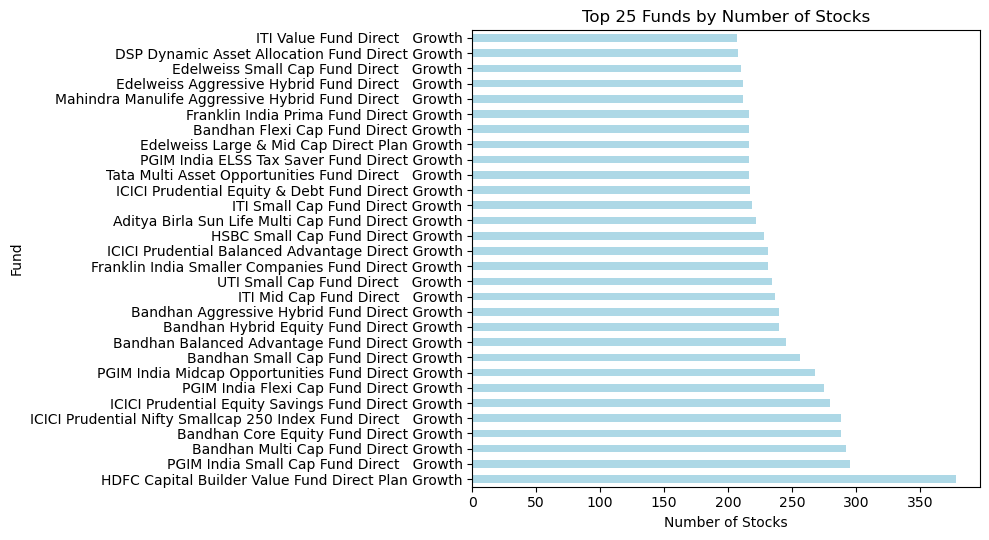

In [116]:
# Fund and Stock Count 

df_stocks.groupby('Fund')['Stock'].count().sort_values(ascending=False).head(30).plot(kind='barh', color='lightblue', figsize=(10,5.5), title='Top 25 Funds by Number of Stocks')
plt.xlabel('Number of Stocks')
plt.tight_layout()
plt.show()


#### A.2 Creating the Fund to Stocks Bipartitie Network 

Nodes: Represent both funds and stocks.  
Edges: Represent the relationship between funds and the stocks they invest in. The weight of the edge could be the percentage invested in the stock by the fund.

In [117]:
# Sector-level total investment
sector_total_investment = df_stocks.groupby('Sector')['Stock Investment'].sum().round(2).reset_index()
sector_total_investment.columns = ['Sector', 'Sector_Total_Investment']

# Stock-level total investment
stock_total_investment = df_stocks.groupby(['Stock', 'Sector'])['Stock Investment'].sum().round(2).reset_index()
stock_total_investment.columns = ['Stock', 'Sector', 'Stock_Total_Investment']

# merging
stock_sector_pct = pd.merge(stock_total_investment, sector_total_investment, on='Sector', how='left')
stock_sector_pct['Stock_Sector_Contribution_%'] = (
    100 * stock_sector_pct['Stock_Total_Investment'] / stock_sector_pct['Sector_Total_Investment']
).round(2)

# Top 20 Holdings (overall)
top_20_df = stock_sector_pct.sort_values(by='Stock_Total_Investment', ascending=False).head(20)

In [118]:
# Plotting Top 20 Stock Holdings by % of Sector Investment
# i.e. how much a stock is being invested in of the total investment in a certain sector
#
#
# plot of % investments
fig = px.treemap(
    top_20_df,
    path=['Sector', 'Stock'],
    values='Stock_Sector_Contribution_%',
    color='Sector',
    hover_data={
        'Stock_Total_Investment': ':.2f',
        'Sector_Total_Investment': ':.2f',
        'Stock_Sector_Contribution_%': ':.2f'
    }
)

# Formatting the hover box text
fig.update_traces(
    textinfo='label',                                           # only label in the box 
    hovertemplate=(                                             
        "<b>%{label}</b><br>"                                   # label show
        "Investment: %{customdata[0]:,.2f}<br>"                 # hover_data[0]
        "Sector Total: %{customdata[1]:,.2f}<br>"               # hover_data[1]
        "Share in Sector: %{customdata[2]:.2f}%<extra></extra>" # hover_data[2]
    )
)

# Formatting the layout
fig.update_layout(
    title="Top 20 Stock Holdings by % of Sector Investment",
    title_font_size=20,
    title_x=0.5,
    margin=dict(t=50, l=5, r=25, b=25)
)

fig.show()


In [119]:
# Stock investments as % of total investments in that stock & Sector Investments
#  
# Merge total investment per stock into the original dataframe
df_stocks = pd.merge(df_stocks, stock_total_investment[['Stock', 'Stock_Total_Investment']], on='Stock', how='left') # left join for Stocks

# Calculate percentage investment of fund in that stock
df_stocks['Pct_Investment_by_Fund_in_Stock'] = (
    df_stocks['Stock Investment'] / df_stocks['Stock_Total_Investment'] * 100
).round(5)

# also merging the sector info.
df_stocks = pd.merge(df_stocks, stock_sector_pct[['Stock', 'Sector_Total_Investment',
       'Stock_Sector_Contribution_%']], on='Stock', how='left') # left join for Stocks
# df_stocks

# Check results
# df_stocks[['Fund', 'Stock', 'Stock Investment', 'Stock_Total_Investment', 'Pct_Investment_by_Fund_in_Stock','Sector_Total_Investment',
# 'Stock_Sector_Contribution_%']].head()



In [120]:
# df_stocks[['Fund', 'Stock', 'Stock_Total_Investment', 'Pct_Investment_by_Fund_in_Stock', 'Sector_Total_Investment','Stock_Sector_Contribution_%']]

In [121]:
# Total Number of Funds
print(f"Total Number of Funds: {len(df_stocks['Fund'].unique())}")

# Total NUmber of Stocks
print(f"Total Number of Stocks: {len(df_stocks['Stock'].unique())}")


Total Number of Funds: 517
Total Number of Stocks: 923


In [122]:
df_stocks.columns

Index(['Fund', 'Category', 'Fund_Cap_Category', 'Risk_Profile', 'NAV',
       'Expense_Ratio', 'Sector', 'Stock', 'Percentage_Invested_in_Stock',
       'Fund_AUM', 'Stock Investment', 'Instrument_Type', 'Fund Managers',
       'Alpha', 'Sharpe', 'Returns_3y', 'Stock_Total_Investment',
       'Pct_Investment_by_Fund_in_Stock', 'Sector_Total_Investment',
       'Stock_Sector_Contribution_%'],
      dtype='object')

In [125]:
# df_stocks.to_csv("df_stocks.csv")

Overview: The data shows that we have overall 517 funds and 923 Stocks in which these funds invests.  
Note: These stocks are only equity focussed, so in real, the count is more.

In [126]:
# Initializing an empty graph
B = nx.Graph()

# Fund Nodes
for fund in df_stocks['Fund'].unique():
    fund_info = df_stocks[df_stocks['Fund'] == fund].iloc[0] # converted to series before hand so easy to access values directly
    B.add_node(fund,
               bipartite=0,
               category=fund_info['Category'],
               cap=fund_info['Fund_Cap_Category'],
               risk=fund_info['Risk_Profile'],
               nav=fund_info['NAV'],
               expense_ratio=fund_info['Expense_Ratio'],
               aum=fund_info['Fund_AUM'],
               # manager=fund_info['Fund Managers'],
               alpha=fund_info['Alpha'],
               sharpe=fund_info['Sharpe'],
               returns_3y=fund_info['Returns_3y']
    )

# Stock Nodes
for stock in df_stocks['Stock'].unique():
    stock_df = df_stocks[df_stocks['Stock'] == stock]
    B.add_node(stock,
               bipartite=1,
               sector=stock_df['Sector'].iloc[0],
               instrument = stock_df['Instrument_Type'].iloc[0],

               # Aggregates
               stock_overall_investment = stock_df['Stock_Total_Investment'].iloc[0],
               sector_overall_investment = stock_df['Sector_Total_Investment'].iloc[0],
               stock_sector_contribution_pct = stock_df['Stock_Sector_Contribution_%'].iloc[0]
    )

# Edges with weight = Pct_Investment_by_Fund_in_Stock                                                # Separate for each fund-stock relationship
edges = df_stocks[['Fund', 'Stock', 'Pct_Investment_by_Fund_in_Stock']].values
for fund, stock, weight in edges:
    B.add_edge(fund, stock, weight=weight)


# Adding nodes with the node attribute "bipartite"
funds = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
stocks = [n for n, d in B.nodes(data=True) if d['bipartite'] == 1]


In [127]:
# Network Parameters
print(f"Number of Nodes: {B.number_of_nodes()}")
print(f"Number of Edges: {B.number_of_edges()}")

# Average Degree for All Nodes
print(f"Average degree (overall): {sum(dict(B.degree()).values()) / B.number_of_nodes():.2f}")         # average degree = sum of all degrees/ Total number of nodes 

# Average Degree per Bipartite Set
fund_degrees = dict(B.degree(funds))
stock_degrees = dict(B.degree(stocks))

# Average degree
avg_fund_degree = sum(fund_degrees.values()) / len(funds)
avg_stock_degree = sum(stock_degrees.values()) / len(stocks)

print(f"Average degree of fund nodes: {avg_fund_degree:.2f}")
print(f"Average degree of stock nodes: {avg_stock_degree:.2f}")

Number of Nodes: 1440
Number of Edges: 23057
Average degree (overall): 32.02
Average degree of fund nodes: 44.60
Average degree of stock nodes: 24.98


**Overview**  
* On average, each node in the graph (both, fund or stock) is connected to ~ 32 other nodes.
* Fund nodes are connected to ~45 stocks on average.  
* Stock nodes are connected to ~25 funds on average.  

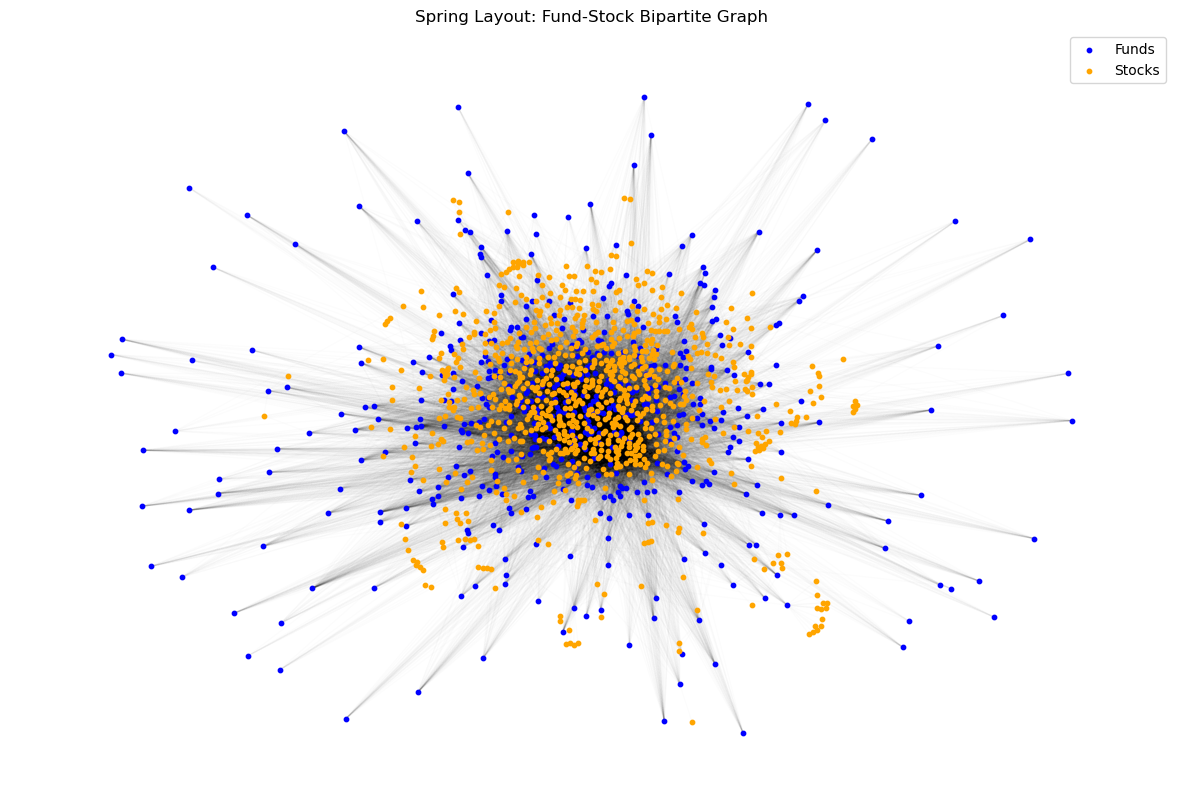

In [128]:
# Compute the layout for positioning nodes using the spring layout algorithm

pos = nx.spring_layout(B, k=0.2, seed=42)                         # dict of node positions | k to control spacing (smaller gives tight layout), and seed makes it reproducible

# Plot initialization
plt.figure(figsize=(15, 10))

# Fund Nodes
nx.draw_networkx_nodes(B, pos, nodelist=funds, node_color='blue', node_size=10, label='Funds')      # Blue Nodes for Funds

# Stock Nodes
nx.draw_networkx_nodes(B, pos, nodelist=stocks, node_color='orange', node_size=10, label='Stocks')  # Orange Nodes for Stocks

# Edges
nx.draw_networkx_edges(B, pos, alpha=0.01)                                                          # Edges
# nx.draw_networkx_labels(B, pos, font_size=6)                                                      # label not printed for clarity

# Plot settings
plt.title("Spring Layout: Fund-Stock Bipartite Graph")
plt.axis('off')
plt.legend()
plt.show()

In [ ]:
# saving the Graph for gephi
nx.write_gexf(B, "fund_stock_bipartite_graph.gexf")

# saving in Graphml format also 
# nx.write_graphml(B, "fund_stock_graph.graphml")

In [130]:
# Top Funds by weights  | (can also get directly by AUM) |  but here we are only considering the Stocks (Equity Market) so it is less than overall AUM                                                           weighted_degrees = B.degree(weight='weight')
top_funds_by_weight = [
    (n, round(d, 2))                             # rounding the weights 2 decimals
    for n, d in B.degree(weight='weight')
    if B.nodes[n]['bipartite'] == 0
]
top_funds_by_weight = sorted(top_funds_by_weight, key=lambda x: x[1], reverse=True)

pd.DataFrame(top_funds_by_weight, columns=['Fund', 'Weighted Amount'])

Fund  Weighted Amount
0           Nippon India Small Cap Fund Direct  Growth          1188.69
1                     DSP Small Cap Direct Plan Growth          1167.65
2                   HDFC Small Cap Fund Direct  Growth          1166.40
3                  Tata Small Cap Fund Direct   Growth          1153.08
4    ICICI Prudential Smallcap Fund Direct Plan Growth          1121.73
..                                                 ...              ...
512   Franklin India Debt Hybrid Fund A Direct  Growth             0.04
513             DSP Regular Savings Fund Direct Growth             0.02
514  Aditya Birla Sun Life Retirement Fund   The 50...             0.02
515  Sundaram Conservative Hybrid Fund Direct Plan ...             0.01
516  SBI Retirement Benefit Fund   Conservative Pla...             0.01

[517 rows x 2 columns]

#### A.3 Creating the Fund-Fund Projection Network

##### A.3.1 Full Projection Network (Overall Network) 

The Bipartite Fund-Stock network is now being transformed into Fund-Fund one more projection network. It will help identify clusters of funds that are majorly investing in the similar equities and also help find any clusters. Further, it might help identify any outlier funds (if any). 

Here Each Node is a separate fund  
The connection between nodes specify that the two funds are commonly investing in a stock
The edge weights specifes the common shares holding.


In [131]:
from networkx.algorithms import bipartite

# Get the set of fund nodes (bipartite=0)
fund_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]

# Create the Fund–Fund projection graph
fund_fund_proj = bipartite.weighted_projected_graph(B, fund_nodes)

# saving the Graph
nx.write_gexf(fund_fund_proj, "fund_fund_projection.gexf")


Analyzing Fund-Fund Node attributes

In [159]:
# Number of Fund Nodes and Edges
print(f"Number of Funds (Nodes): {fund_fund_proj.number_of_nodes()}")
print(f"Number of Fund–Fund Edges: {fund_fund_proj.number_of_edges()}")

# Edge weight statistics
weights = [d['weight'] for u, v, d in fund_fund_proj.edges(data=True)]
print(f"Edge Weight - Min: {min(weights):.2f}, Max: {max(weights):.2f}, Mean: {sum(weights)/len(weights):.2f}")

# density 
print(f"Graph Density: {nx.density(fund_fund_proj):.4f}") # network density (2L/N(N-1))

# Other network metrics
diameter_ff = nx.diameter(fund_fund_proj) if nx.is_connected(fund_fund_proj) else "Not connected"
avg_path_length_ff = nx.average_shortest_path_length(fund_fund_proj) if nx.is_connected(fund_fund_proj) else "N/A"
radius_ff = nx.radius(fund_fund_proj) if nx.is_connected(fund_fund_proj) else "N/A"

print(f"Fund-Fund Graph - Diameter: {diameter_ff}")
print(f"Fund-Fund Graph - Radius: {radius_ff}")
print(f"Fund-Fund Graph - Average Path Length: {avg_path_length_ff}")

Number of Funds (Nodes): 517
Number of Fund–Fund Edges: 126786
Edge Weight - Min: 1.00, Max: 100.00, Mean: 9.44
Graph Density: 0.9505
Fund-Fund Graph - Diameter: 2
Fund-Fund Graph - Radius: 1
Fund-Fund Graph - Average Path Length: 1.049480455220188


Thus, there are overall 517 funds in the network with 126786 edges, and the density of 95% (very high). This shows that almost each fund is connected to almost every other fund, and the funds having overlapping investment assets.
Note: The overlapping is based on even if thre is 1 common stock between the funds.

##### Comparison with Erdős–Rényi (ER) graph

In [154]:
# Real network parameters
num_nodes = fund_fund_proj.number_of_nodes()
density = nx.density(fund_fund_proj)

# Generate ER random graph
G_er = nx.erdos_renyi_graph(n=num_nodes, p=density, seed=42)

In [160]:
# Network Statistics
print(f"ER Graph - Nodes: {G_er.number_of_nodes()}")
print(f"ER Graph - Edges: {G_er.number_of_edges()}")

# Calculate network metrics
diameter_er = nx.diameter(G_er) if nx.is_connected(G_er) else "Not connected"
avg_path_length_er = nx.average_shortest_path_length(G_er) if nx.is_connected(G_er) else "N/A"
radius_er = nx.radius(G_er) if nx.is_connected(G_er) else "N/A"

print(f"ER Graph - Diameter: {diameter_er}")
print(f"ER Graph - Radius: {radius_er}")
print(f"ER Graph - Average Path Length: {avg_path_length_er}")
print(f"ER Graph - Density: {nx.density(G_er):.4f}")

ER Graph - Nodes: 517
ER Graph - Edges: 126733
ER Graph - Diameter: 2
ER Graph - Radius: 2
ER Graph - Average Path Length: 1.0498777982696834
ER Graph - Density: 0.9501


**Overview**  
Both the Real and ER network have a diameter of 2, thus representing small world network (most funds connected to each other using at least one stock, thius a small world of investments in limited stocks).
Further the real network has a more centralized hub as the radius of it is 1, compared to ER network. Given real graph with radius 1, indicates at least one fund is directly connected to every other fund. However, for ER graph with radius 2, there is no ultra-central hub showing that the connections are more uniform.

In [163]:
# Clustering Coefficients of the Two Networks : 
print(f"Clustering Coefficient of Real Network: {nx.average_clustering(fund_fund_proj)}")
print(f"Clustering Coefficient of the ER Network: {nx.average_clustering(G_er)}")

Clustering Coefficient of Real Network: 0.9599113947322792
Clustering Coefficient of the ER Network: 0.9501338437785521


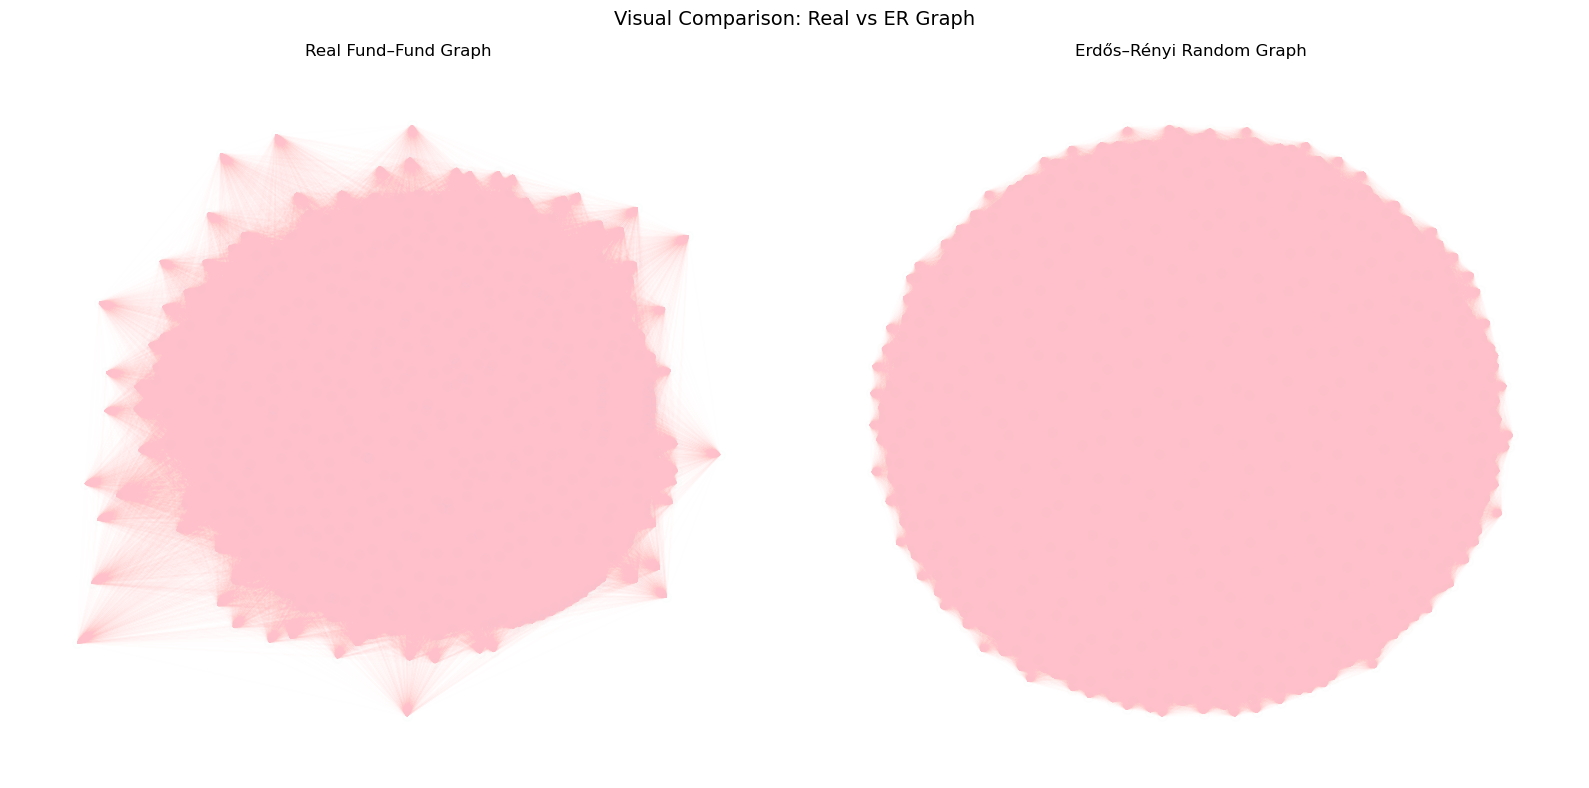

In [ ]:
# Plotting the Graphs 
# Using Kamada Kawai layout

# Generate graph layouts
pos_real = nx.kamada_kawai_layout(fund_fund_proj) #, seed=42)
pos_er = nx.kamada_kawai_layout(G_er) #, seed=42)

plt.figure(figsize=(16, 8))

# Real graph
plt.subplot(1, 2, 1)
nx.draw(fund_fund_proj, pos_real, node_size=50, node_color='skyblue', edge_color='pink', alpha=0.010, with_labels=False)
plt.title("Real Fund–Fund Graph")

# ER graph
plt.subplot(1, 2, 2)
nx.draw(G_er, pos_er, node_size=50, node_color='lightgreen', edge_color='pink', alpha=0.010, with_labels=False)
plt.title("Erdős–Rényi Random Graph")

plt.suptitle("Visual Comparison: Real vs ER Graph", fontsize=14)
plt.tight_layout()
plt.show()

Let's filter the network to prune weak edges, with a threshold of 10 stocks, i.e. Fund - Fund edge connection is established only if any of the top 10 investments in a specific funds are common.  

In [133]:
# Sorted by % of AUM invested in each stock → Top 10 for each fund
fund_top10 = (
    df_stocks
    .sort_values(['Fund', 'Percentage_Invested_in_Stock'], ascending=[True, False])
    .groupby('Fund')['Stock']
    .head(10)
    .groupby(df_stocks['Fund'])  # needed again after head()
    .apply(set)
    .to_dict()
)

##### A.3.2 Network based on Overlaping Assets/ Stocks in Top 10 Holdings

In [134]:
# New graph for overlapping in top 10
G_top10_overlap = nx.Graph()

# Add fund nodes with attributes
G_top10_overlap.add_nodes_from([
    (fund, B.nodes[fund]) for fund in fund_top10.keys()
])

# Compare all pairs of funds
fund_list = list(fund_top10.keys())

for f1, f2 in itertools.combinations(fund_list, 2):             # Checking the intersection of Sets (values) to create the edge 
    overlap = fund_top10[f1].intersection(fund_top10[f2])
    if len(overlap) > 0:
        G_top10_overlap.add_edge(f1, f2, weight=len(overlap))

In [135]:
# saving the Graph
nx.write_gexf(G_top10_overlap, "G_top10_overlap.gexf")

In [136]:
# Node statistics
print(f"Node Statistics in G_top10_overlap Network: ")
print(f"Number of Nodes (i.e. Number of Funds): {G_top10_overlap.number_of_nodes()}")
print(f"Number of Edges (i.e. Funds' Connections if any common holding in top 10 Holdings): {G_top10_overlap.number_of_edges()}")

weights_10 = [d['weight'] for u, v, d in G_top10_overlap.edges(data=True)]
print(f"Edge Weight - Min: {min(weights_10):.2f}, Max: {max(weights_10):.2f}, Mean: {sum(weights_10)/len(weights_10):.2f}")

print(f"Network Density (i.e. % of connections to total possible connections): {nx.density(G_top10_overlap):.4f}")

Node Statistics in G_top10_overlap Network: 
Number of Nodes (i.e. Number of Funds): 517
Number of Edges (i.e. Funds' Connections if any common holding in top 10 Holdings): 77334
Edge Weight - Min: 1.00, Max: 10.00, Mean: 2.29
Network Density (i.e. % of connections to total possible connections): 0.5798


Comparison of All Holding and Top 10 Holding Network Statistics 

In [137]:
# Comparing the two networks
print("                     Fund Network Comparison             ")
print("-" * 60)
print(f"{'Metric':<30}{'All Holdings':<15}{'Top 10 Holdings':<15}")
print("-" * 60)
print(f"{'Number of Fund Nodes':<30}{fund_fund_proj.number_of_nodes():<15}{G_top10_overlap.number_of_nodes():<15}")
print(f"{'Number of Fund - Fund Edges':<30}{fund_fund_proj.number_of_edges():<15}{G_top10_overlap.number_of_edges():<15}")
print(f"{'Edge Weight - Minimum':<30}{min(weights):<15.2f}{min(weights_10):<15.2f}")
print(f"{'Edge Weight - Maximum':<30}{max(weights):<15.2f}{max(weights_10):<15.2f}")
print(f"{'Edge Weight - Mean':<30}{sum(weights)/len(weights):<15.2f}{sum(weights_10)/len(weights_10):<15.2f}")
print(f"{'Graph Density':<30}{nx.density(fund_fund_proj):<15.4f}{nx.density(G_top10_overlap):<15.4f}")

                     Fund Network Comparison             
------------------------------------------------------------
Metric                        All Holdings   Top 10 Holdings
------------------------------------------------------------
Number of Fund Nodes          517            517            
Number of Fund - Fund Edges   126786         77334          
Edge Weight - Minimum         1.00           1.00           
Edge Weight - Maximum         100.00         10.00          
Edge Weight - Mean            9.44           2.29           
Graph Density                 0.9505         0.5798         


**Overview**
* From above metrics, we see that the network made by considering the "Top 10 Holdings" has significantly less number of edges (reduced by 39%). Thus, it's a sparser network.
* The max edge weight in the latter is 10 (which means there are funds that share the whole top 10 holdings), thus it means the MF's are more or less the same with less diversity to portfolio.  
* Normally funds shared ~9 stocks in overall network, but only ~2 from top 10. This shows lower similarity on key holdings.
* Full graph is nearly fully connected (~95%), but top 10 overlap graph is much less dense (~58%). This makes it more useful for distinguishing strong vs weak overlaps.

##### A.3.3 Network Graph for Common Stocks in Top 10 Holdings 

In [138]:
# Funds data from the graph
fund_attr_df = pd.DataFrame.from_dict(dict(G_top10_overlap.nodes(data=True)), orient='index')
fund_attr_df.info()
# fund_attr_df
fund_attr_df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 517 entries, 360 ONE Focused Equity Fund Direct Growth to Union Value Fund Direct   Growth
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bipartite      517 non-null    int64  
 1   category       517 non-null    object 
 2   cap            517 non-null    object 
 3   risk           517 non-null    object 
 4   nav            517 non-null    float64
 5   expense_ratio  517 non-null    float64
 6   aum            517 non-null    float64
 7   alpha          517 non-null    float64
 8   sharpe         517 non-null    float64
 9   returns_3y     517 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 44.4+ KB


bipartite          nav  expense_ratio           aum       alpha  \
count      517.0   517.000000     517.000000    517.000000  517.000000   
mean         0.0   176.056673       0.770348   6723.651431    2.097814   
std          0.0   356.356478       0.354302  11759.444447    3.019329   
min          0.0    11.010000       0.070000      8.790000  -13.260000   
25%          0.0    24.490000       0.550000    676.450000    0.050000   
50%          0.0    54.770000       0.740000   2131.250000    1.770000   
75%          0.0   172.210000       0.990000   7532.740000    4.090000   
max          0.0  4424.470000       2.580000  98541.280000   13.430000   

           sharpe  returns_3y  
count  517.000000  517.000000  
mean     0.764855   17.798066  
std      0.241842    7.667881  
min     -0.350000  -11.400000  
25%      0.590000   13.200000  
50%      0.750000   18.300000  
75%      0.930000   22.800000  
max      1.490000   38.600000

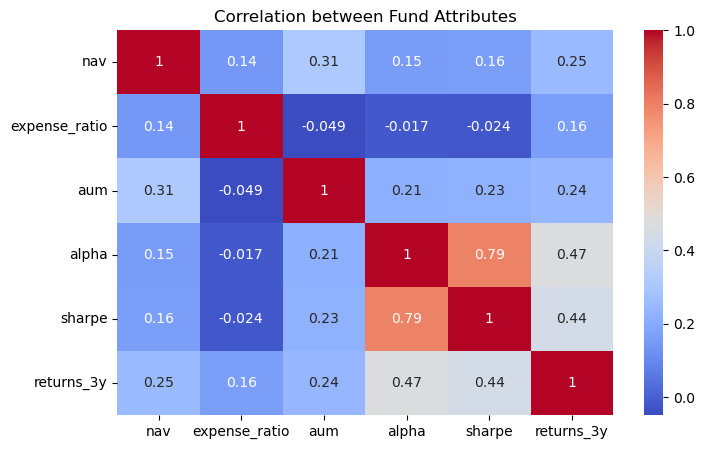

In [139]:
# Correlation PLot
plt.figure(figsize=(8,5))
filtered_df = fund_attr_df.drop(columns=['bipartite'])
sns.heatmap(filtered_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation between Fund Attributes")
plt.show()

**Overview**  
*The correlation plots shows a high correlation between **Alpha** and **Sharpe Ratio**. The alpha denotes the excess returns over average market returns that a fund has generated, and Sharpe Ratio denotes the Returns per unit of Risk taken for that fund. Further, alpha and Sharpe ratio is also correlated with returns (which is expected) and is also a parameter for Mutual Fund selection.*

Visualizing the Degree centrality along with Fund Category, Returns, Alpha and Risk

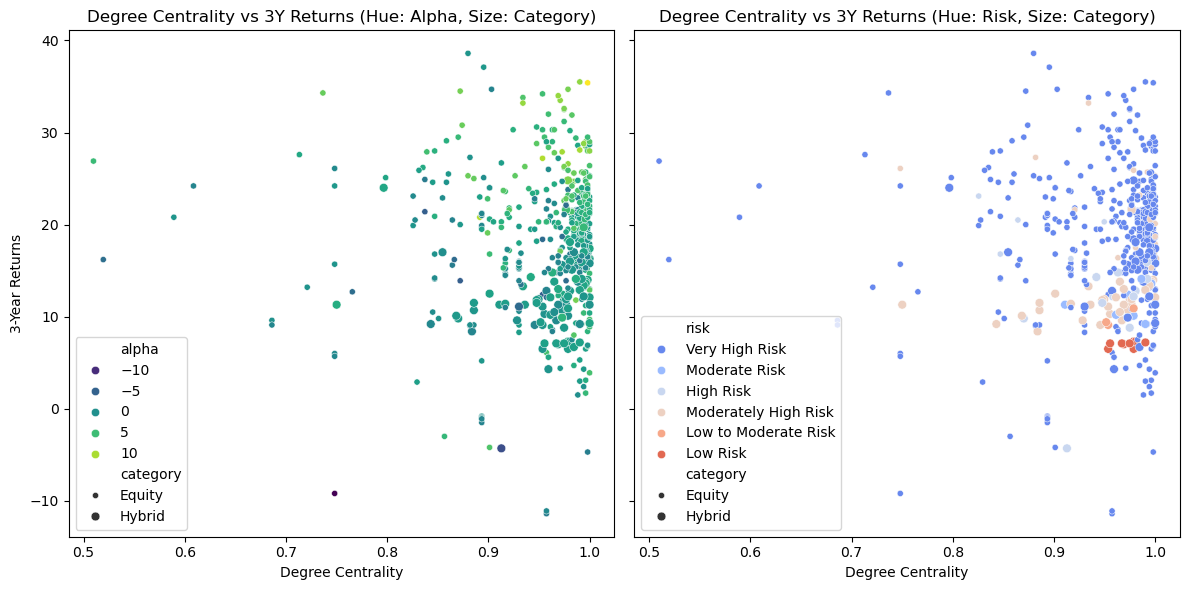

In [140]:
# Degree Centrality
deg_cent = nx.degree_centrality(fund_fund_proj)
fund_attr_df['degree_centrality'] = fund_attr_df.index.map(deg_cent)

# Generating the plots for different parameters

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Scatterplot 1: Hue = 'alpha', Size based on 'category' (equity vs hybrid)
sns.scatterplot(data=fund_attr_df, x='degree_centrality', y='returns_3y',
                hue='alpha', size='category', ax=axes[0], sizes=(40, 20), palette='viridis')
axes[0].set_title("Degree Centrality vs 3Y Returns (Hue: Alpha, Size: Category)")

# Scatterplot 2: Hue = 'risk', Size based on 'category' (equity vs hybrid)
sns.scatterplot(data=fund_attr_df, x='degree_centrality', y='returns_3y',
                hue='risk', size='category', ax=axes[1], sizes=(40, 20), palette='coolwarm')
axes[1].set_title("Degree Centrality vs 3Y Returns (Hue: Risk, Size: Category)")

# Plot Layout
for ax in axes:
    ax.set_xlabel("Degree Centrality")
    ax.set_ylabel("3-Year Returns")

plt.tight_layout()
plt.show()

**Observations from the plots are as follows:**  
* From the plots we see that most of the funds have a higher degree centrality, thus most of the funds are very well interconnected.
* It denotes that among the top 10 holdings of the funds, they do share the common assets. These funds are likely to have overlapping portfolios or share investments in popular assets.  
* Further, we can also see that most of the funds provide average returns from **~7%** to under **20%**.  
* The **"Low Risk"** funds provides on average less thatn 10% returns for a period of 3 years (which are typically Arbitrage Funds)  
* The returns for **"Very High Risk"** funds are more diverse and span the whole area, with major clustering for over **10%** returns.  
* But at the same time, the funds under categories, **"Moderately High Risk"** and **"Low to Moderate Risk"** are providing at least around **9-10%** returns over 3years period.  

Since the data is very congested, I decided to use K-Means to cluster funds into groups, and see how it compares to the Communities.

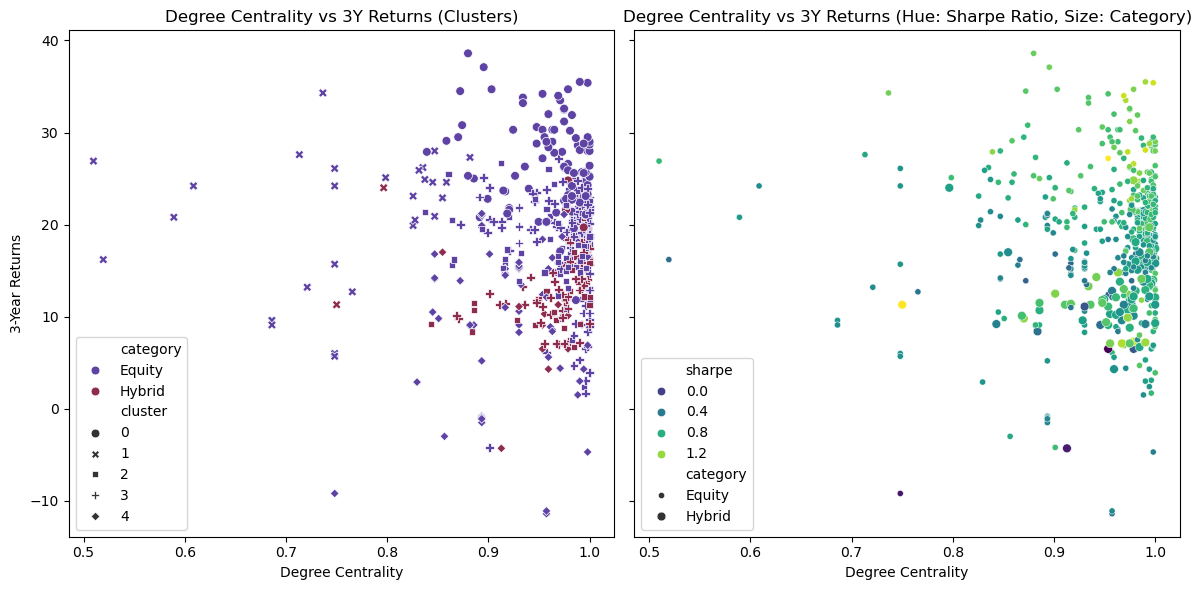

In [141]:
# Select the features to use for clustering (degree centrality, returns, Sharpe ratio, expense ratio)
features = fund_attr_df[['degree_centrality', 'returns_3y', 'sharpe', 'alpha', 'expense_ratio']]

# Normalize the features (for K-means)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-means clustering with k clusters (k selected using Elbow-method)
# From elbow method, K comes out to be 5, just the way there are 5 Cluters using the Networkx (provided later in the script)
kmeans = KMeans(n_clusters=5, random_state=42)
fund_attr_df['cluster'] = kmeans.fit_predict(features_scaled)

# Set up subplots (2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Scatterplot 1: Hue = 'cluster' for K-means clusters
sns.scatterplot(data=fund_attr_df, x='degree_centrality', y='returns_3y',
                hue='category', style='cluster', ax=axes[0], palette='twilight', s=40)
axes[0].set_title("Degree Centrality vs 3Y Returns (Clusters)")

# Scatterplot 2: Hue = 'sharpe', Size based on 'category' (equity vs hybrid)
sns.scatterplot(data=fund_attr_df, x='degree_centrality', y='returns_3y',
                hue='sharpe', size='category', ax=axes[1], sizes=(40, 20), palette='viridis')
axes[1].set_title("Degree Centrality vs 3Y Returns (Hue: Sharpe Ratio, Size: Category)")

# Plot Layout
for ax in axes:
    ax.set_xlabel("Degree Centrality")
    ax.set_ylabel("3-Year Returns")

plt.tight_layout()
plt.show()

**Observations**  
The plots show that the Hyprid Funds provides more clusterd and consitent returns with at least ~ 10-15% range, with a few outliers under 10%. This shows that they might be investing in more balanced portfolios (including debt) for more stable returns.  
However, the Equity funds provides diverse returns indicating higher volatility of stock market returns.  

*Clusters Analysis*
* Cluster 0 with High Degree centrality and High Sharpe Ratio (top right corner) are providing the highest returns. The funds might be well-diversified, and hold popular or high-performing assets.  
* Cluster 2 with high degree centrality and average sharpe ratio (thus don't necessarily offer the best risk-adjusted returns) is providing better than average returns.  
* Cluster 4 has comparatively more than average degree centrality, but a low sharpe ratio and comparatively less returns. This hsows that the funds could be more like speculaitve anc concentrated in assets that are more volatile.
* Cluster 1 has funds that have varied level of centrality and sharpe ratio, with varied level of returns (shows uncertain group of funds)
* Cluster 3 shows the funds with more than average degree centrality and more than average Sharpe Ratio, with almost average returns.

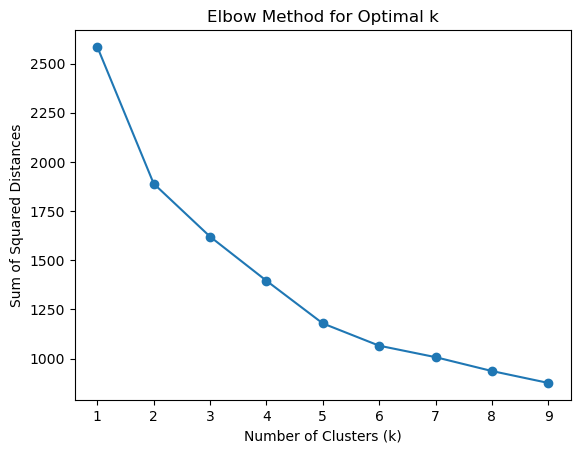

In [142]:
# Selecting the value of k using Elbow Method
inertia = []
for k in range(1, 10):  # Trying different k values
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

Community Detection using Louvain Method  
The Louvain Method algorithm detects communities in networks (graphs) by maximizing modularity. Group funds by investment similarity.

In [143]:
# Generating Communities nad statistics
np.random.seed(42)                                                                          # seed for reproducibility
partition = community_louvain.best_partition(G_top10_overlap)                               # partition into communities
fund_attr_df['community'] = fund_attr_df.index.map(partition)                               # joining the community data in column in df

community_stats = fund_attr_df.groupby('community')[['returns_3y', 'sharpe', 'aum']].mean().round(2) # Community Statistics
community_stats

returns_3y  sharpe       aum
community                              
0               16.43    0.73   5148.30
1               34.50    1.01  10244.10
2               16.18    0.83   9338.30
3               19.19    0.81   8309.33
4               17.94    0.72   4451.82
5               19.48    0.74   6530.10

**Overview**  
From the face of it, "Community 1" stands out with 34.5% returns and a better Sharpe Ratio (1.01) for better risk adjusted returns, but also has highest AUM.  
The Communities 0 & 4 might represent smaller or more conservative fund groups, with comparatively less Sharpe Ratio and low average AUM, with moderate returns.  
The communities 2, 3 & 5 shows funds with a better Sharpe ratio and moderate AUM, with better than average returns.



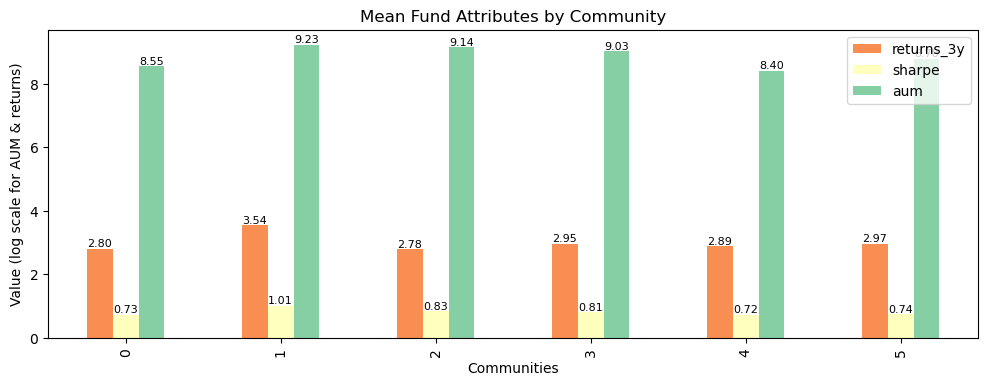

In [144]:
# copy of community_stats DataFrame to avoid modifying original data
community_stats_log = community_stats.copy()
community_stats_log['aum'] = np.log(community_stats_log['aum'])                            # log transforming the AUM for better visualization 
community_stats_log['returns_3y'] = np.log(community_stats_log['returns_3y'])              # log transforming the returns too for visualization on plot axis

# color palette
palette = sns.color_palette("Spectral", len(community_stats_log.columns))

# bar chart for variables
ax = community_stats_log.plot(kind='bar', figsize=(12,4),color=palette)
plt.title("Mean Fund Attributes by Community")
plt.ylabel("Value (log scale for AUM & returns)")
plt.xlabel("Communities")

# Adding value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # x position: center of the bar
        height,                        # y position: top of the bar
        f'{height:.2f}',               # label text formatted to 2 decimals
        ha='center',                   # horizontal alignment
        va='bottom',                   # vertical alignment
        fontsize=8
    )

plt.show()                             # Output the plot

In [ ]:
# Creating a Spyder chart for Community parameters

df = community_stats.copy() 
df_scaled = (df - df.min()) / (df.max() - df.min())        # Min-Max Scaling so values between 0-1

categories = list(df_scaled.columns)
num_vars = len(categories)

fig = go.Figure()
for community in df_scaled.index:                           # looping for each community
    values = df_scaled.loc[community].tolist()              
    # Radar charts need values to loop back to the start
    values += values[:1]                                    # appending the first elemt at the end again
    fig.add_trace(go.Scatterpolar(                          # radar chart object
        r=values,                                           # radius
        theta=categories + [categories[0]],                 # Repeated the label for added extra value
        fill='toself',                                      # Filling inside the polgon
        name=f'Community {community}'                       # label of community
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title="Radar Chart of Community Stats (Normalized)"
)

fig.show()

* The radar chart shows that the "Community 1" has outstanding return along with the best sharpe ratio. Let's see the funds in Community 1

In [146]:
# Funds from "Community 1"
fund_attr_df[fund_attr_df['community'] == 1].head()

bipartite category        cap  \
Bandhan Small Cap Fund Direct Growth          0   Equity  Small Cap   

                                                risk   nav  expense_ratio  \
Bandhan Small Cap Fund Direct Growth  Very High Risk  49.4           0.38   

                                          aum  alpha  sharpe  returns_3y  \
Bandhan Small Cap Fund Direct Growth  10244.1    7.9    1.01        34.5   

                                      degree_centrality  cluster  community  
Bandhan Small Cap Fund Direct Growth           0.872093        0          1

*Interestingly there is only one fund in Community 1 and the returns are massive ~34% annualized over 3 years.*  
*It also shows that the fund is a outlier. It is a "Small Cap", "Very High Risk" fund.* 

*The fund being an outlier also means that the investments are niche Investments with no common investments from any top 10 holdings in any other available fund. This is a strong signal of active management where the fund is less likely to be following broad market trends.* 

Note: The degree centrality of the fund (considering all the assets and even if one is shared among other funds) is 0.87. The degree centrality of 0.87 suggests that this fund has some strong connections to other funds, despite the unique stock picks. It possibly indicate that the fund is connected in the network of investments, but its outlier status (in terms of top stock holdings) is clear. 

In [147]:
# Top Investments for this Fund
print(f"Top 15 Investments of the fund: ")
(df_stocks[df_stocks['Fund']=='Bandhan Small Cap Fund Direct Growth'].groupby(['Stock', 'Sector'])['Stock Investment'].sum().reset_index().sort_values(by='Stock Investment', ascending=False).head(15))

Top 15 Investments of the fund: 


Stock            Sector  \
51                                     Sobha Ltd.      Construction   
28                                  LT Foods Ltd.  Consumer Staples   
59                     The South Indian Bank Ltd.         Financial   
10          Cholamandalam Financial Holdings Ltd.         Financial   
36                             PCBL Chemical Ltd.         Chemicals   
3                                     Arvind Ltd.          Textiles   
62  Yatharth Hospital & Trauma Care Services Ltd.        Healthcare   
2                            Apar Industries Ltd.       Diversified   
41                                       REC Ltd.         Financial   
58                        The Karnataka Bank Ltd.         Financial   
39                 Power Finance Corporation Ltd.         Financial   
48               Shaily Engineering Plastics Ltd.         Chemicals   
19                             Indusind Bank Ltd.         Financial   
20                          Inox Wind Energy Ltd.            Energy   
56                              TVS Holdings Ltd.        Automobile   

    Stock Investment  
51           1282.56  
28            975.24  
59            954.76  
10            897.40  
36            774.44  
3             749.88  
62            639.24  
2             590.08  
41            585.96  
58            540.88  
39            536.80  
48            516.32  
19            458.92  
20            458.92  
56            450.76

Overview of Top Investments:
The list of top investments is quite diverse, indicating that fund is focussing ov diverse sectors in the Small Cap stocks, which can also be a bet across the emerginf industries with a growth potential.

Comparison of K-Means Clusters with Communities

<Axes: xlabel='cluster', ylabel='community'>

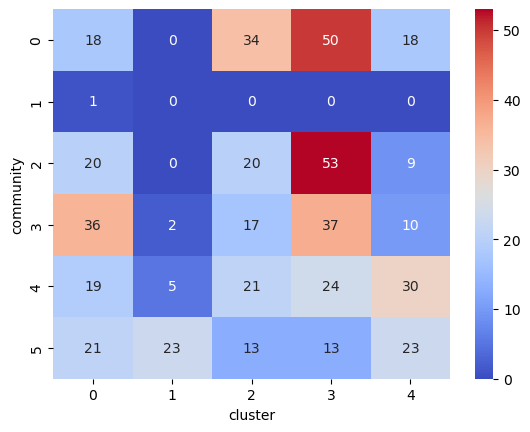

In [148]:
# Cross-tabulation to compare K-means clusters and Louvain communities
cluster_comparison = pd.crosstab(fund_attr_df['community'], fund_attr_df['cluster'])

# Heatmap
sns.heatmap(cluster_comparison,annot=True, cmap='coolwarm')

**Overview**  
* Row -> Communities (Louvain)  
* Column -> Clusters (K-means)  
Most of the funds in "Community 0" (18, 34, 50, 18) are spread across Clusters 0, 2, 3 & 4. For Cluster 3, the 50 funds have similar characrteristics and are also heavily networked in the community.  
"Community 1", there is only 1 fund in Cluster 0 showing a low network overlap with other funds, and potentially, this fund is an outlier in terms of its performance characteristics.  
"Community 2" also has highes number of funds in cluster 3, showing that the cluster 3 is the most networked cluster.
"Community 3" has funds distributed in various clusters so does Community 4 & 5.  

*From  the cross-tabulation between Louvain communities and K-means clusters, it can be seen that the funds are more segregated than unified. There is no significant overlap between the two grouping methods, suggesting that the network relationships (how funds share assets) do not strongly align with the performance-based features (such as degree centrality, returns, Sharpe ratio, etc.).*  

*The lack of alignment supports the hypothesis that network structure and performance characteristics might be capturing different aspects of fund behavior.*  

*This outcome reinforces the idea that network analysis and traditional performance-based clustering might capture distinct dimensions of fund behavior and that a hybrid approach that combines both network and performance-based features could provide a more comprehensive understanding of fund dynamics.*  

### B. Plots/ Images for the Three Graphs Drawn

##### B. 1. Plot 1 | Fund-Stock Bipartite Graph

*The below plot shows the Bipartite Graph between Funds and Stocks.*  

**Green** Nodes are Funds, and the size of node indicates the AUM of the Fund. Thus larger Size indicates Higher AUM (Assets under management).  
**Red** Nodes are Stocks, and the size of nodes indicated the degree of nodes. Larger node indicates that more funds are investing in that fund.

Further the edge weight denotes the % of a fund invested in that stock as per the total % of overall amount invested in that stock.


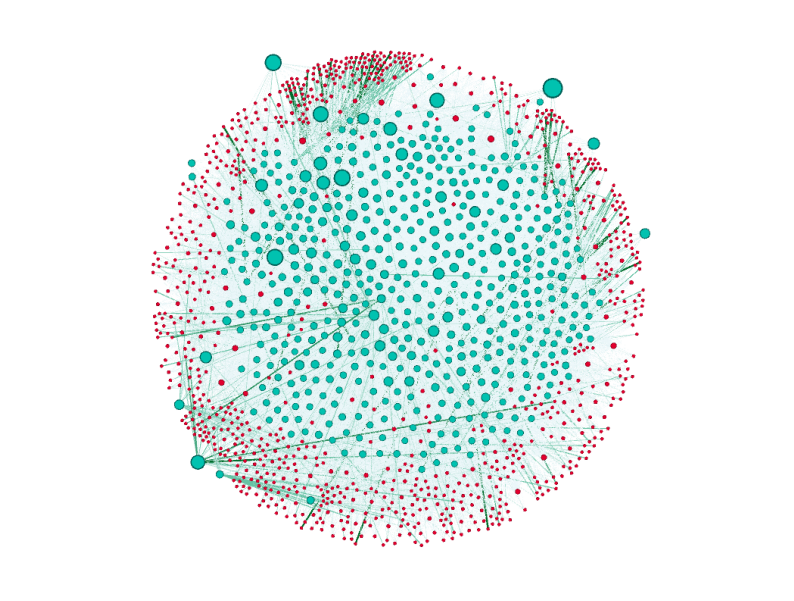

In [ ]:
import matplotlib.image as mpimg

# Bipartite Grapgh of Funds and Stocks
img = mpimg.imread("Network_Images/Fund_Stock_Bipartite_Graph.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

##### B. 2. Plot 2 | Fund-Fund Projected Graph (Overall)

*The below plot shows the Projected Graph, Funds to Funds Graph.*  

The nodes are colored as per the Risk Profile :   
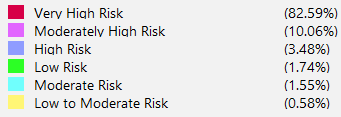

The size of node denotes the 3year returns, larger the node higher the returns.

Further the edge weight denotes the number of stocks shared between different funds.


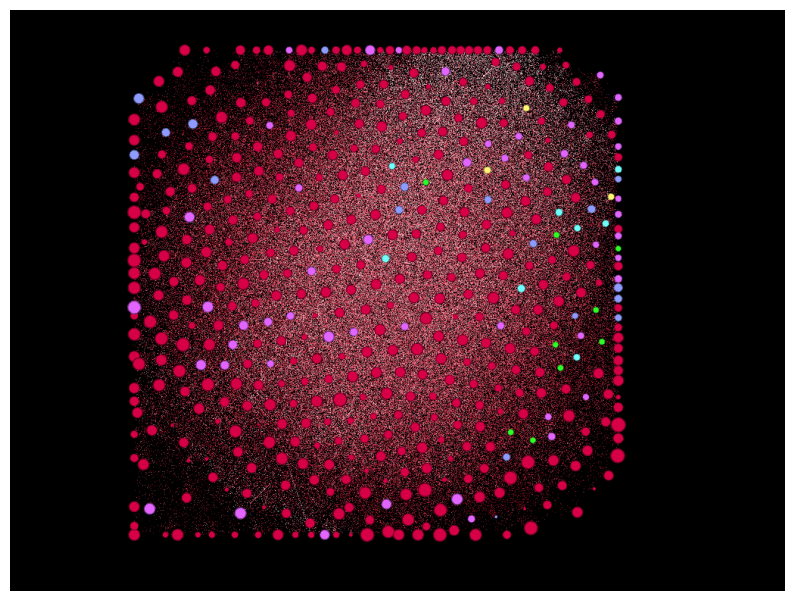

In [ ]:
# Fund Fund Projected Overall of Funds and Stocks
img = mpimg.imread("Network_Images/Fund_Fund_Overall_Projected Network.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

##### B. 3. Plot 3 | Fund-Fund Projected Graph (Top 10)  

*The below plot shows the Projected Graph, Funds to Funds Graph oconsidering an edge only if a fund in top 10 funds overlaps.*  

The nodes are colored as per the Risk Profile :   
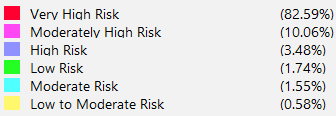

The size of node denotes the 5 Communities.
Further we see an outsider, which is separate from all the nodes, as discussed above for Bandhan Bank Fund.

Further the edge weight denotes the number of stocks shared between different funds.


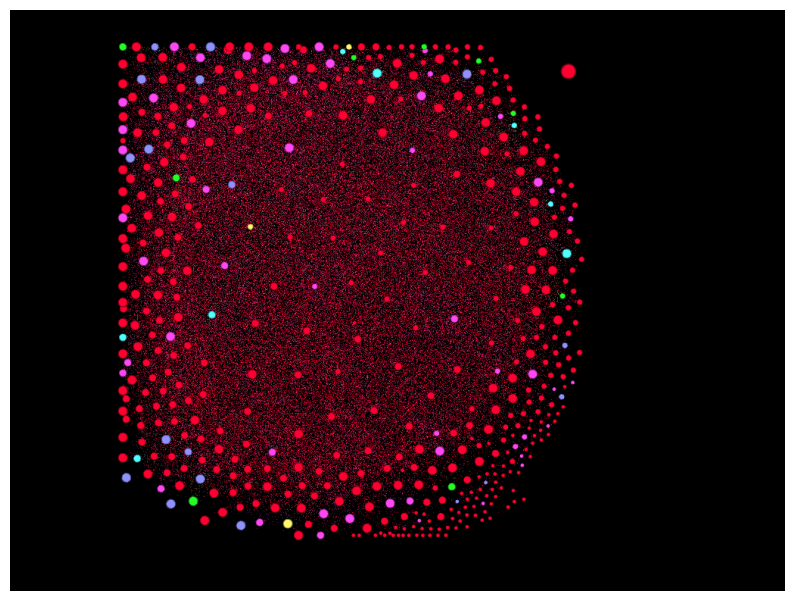

In [ ]:
# Fund Fund Projected Overall of Funds and Stocks
img = mpimg.imread("Network_Images/Fund_Fund_Top_10.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

### C. Insights from the Fund-Fund Network (edge based on Top 10 holdings)

##### C.1 Top 20 Highly Interconnected Fund Pairs

In [ ]:
# Top 20 Highly Interconnected Fund Pairs
top_20_overlap_edges = sorted(G_top10_overlap.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:500] # taking in top 500 for creating a network grapgh
pd.DataFrame([
    {'Fund 1': u, 'Fund 2': v, 'Common Top Stocks': d['weight']}
    for u, v, d in top_20_overlap_edges
])

# % of AUM in Top 10 Stocks in Each Fund (helps identify similar funds, to help manage the redundant investments)
results = []
for u, v, d in top_20_overlap_edges:
    common_stocks = fund_top10[u].intersection(fund_top10[v])
    
    # Get total % AUM invested by each fund in these common stocks
    weight_u = df_stocks[
        (df_stocks['Fund'] == u) & (df_stocks['Stock'].isin(common_stocks))
    ]['Percentage_Invested_in_Stock'].sum()*100

    weight_v = df_stocks[
        (df_stocks['Fund'] == v) & (df_stocks['Stock'].isin(common_stocks))
    ]['Percentage_Invested_in_Stock'].sum()*100
    
    results.append({
        'Fund 1': u,
        'Fund 2': v,
        'Common Top Stocks': len(common_stocks),
        'Fund 1 AUM % in Common Stocks': round(weight_u, 2),
        'Fund 2 AUM % in Common Stocks': round(weight_v, 2)
    })

df_overlap_investment = pd.DataFrame(results)

In [224]:
df_overlap_investment.head(20)          # top 20

Fund 1  \
0   Aditya Birla Sun Life Nifty 50 Equal Weight In...   
1   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
2   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
3   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
4   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
5   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
6   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
7   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
8   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
9   Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
10  Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
11  Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
12  Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
13  Aditya Birla Sun Life Nifty 50 Index Fund Dire...   
14  Aditya Birla Sun Life Nifty Midcap 150 Index F...   
15  Aditya Birla Sun Life Nifty Midcap 150 Index F...   
16  Aditya Birla Sun Life Nifty Next 50 Index Fund...   
17  Aditya Birla Sun Life Nifty Next 50 Index Fund...   
18  Aditya Birla Sun Life Nifty Next 50 Index Fund...   
19  Aditya Birla Sun Life Nifty Next 50 Index Fund...   

                                               Fund 2  Common Top Stocks  \
0   HDFC NIFTY50 Equal Weight Index Fund Direct   ...                 10   
1             Axis Nifty 100 Index Fund Direct Growth                 10   
2          Bandhan Nifty 100 Index Fund Direct Growth                 10   
3      Bandhan Nifty 50 Index Fund Direct Plan Growth                 10   
4            HDFC BSE Sensex Index Fund Direct Growth                 10   
5     HDFC Index Fund   BSE Sensex Plan Direct Growth                 10   
6             HDFC NIFTY 100 Index Fund Direct Growth                 10   
7                  HDFC NIFTY 50 Index Direct  Growth                 10   
8             HDFC NIFTY 50 Index Fund Direct  Growth                 10   
9         LIC MF BSE Sensex Index Fund Direct  Growth                 10   
10           LIC MF Nifty 50 Index Fund Direct Growth                 10   
11          Mirae Asset Large Cap Fund Direct  Growth                 10   
12  Motilal Oswal Nifty 50 Index Fund Direct   Growth                 10   
13  Nippon India Index Fund Nifty 50 Plan Direct  ...                 10   
14  Motilal Oswal Nifty Midcap 150 Index Fund Dire...                 10   
15  Nippon India Nifty Midcap 150 Index Fund Direc...                 10   
16        Axis Nifty Next 50 Index Fund Direct Growth                 10   
17      HDFC NIFTY Next 50 Index Fund Direct   Growth                 10   
18      LIC MF Nifty Next 50 Index Fund Direct Growth                 10   
19  Motilal Oswal Nifty Next 50 Index Fund Direct ...                 10   

    Fund 1 AUM % in Common Stocks  Fund 2 AUM % in Common Stocks  
0                           22.03                          22.11  
1                           56.91                          47.32  
2                           56.91                          47.27  
3                           56.91                          56.94  
4                           56.91                          67.18  
5                           56.91                          67.18  
6                           56.91                          47.25  
7                           56.91                          56.97  
8                           56.91                          56.97  
9                           56.91                          67.10  
10                          56.91                          56.64  
11                          56.91                          49.10  
12                          56.91                          56.89  
13                          56.91                          56.94  
14                          18.59                          18.59  
15                          18.59                          18.68  
16                          32.35                          32.33  
17                          32.35             

The Top 20 Fund pairs shows that the funds have 10/10 common top holdings, especially among Nifty 50, Sensex, and Nifty 100 index funds. Further even top 119 funds have 10/10 top holdings.  

These overlaps are not just symbolic, as the funds generally have >=40-50% of AUM invested in common stocks.  
This suggests high exposure concentration, which increases portfolio similarity risk, example, HDFC Index Fund – Sensex Plan and Aditya Birla Sun Life Nifty 50, they both have over 56% AUM in same stocks.

The similarity is majorly in Nifty Index funds (apssive in nature), however for Midcap Index, the funds show less contribution of AUM in similar stocks, example, Aditya Birla Sun Life Nifty Midcap 150 Index Fund Direct Growth & Motilal Oswal Nifty Midcap 150 Index Fund Direct Growth with ~18.59%.



In [ ]:
G_overlap_AUM = nx.Graph()

for _, row in df_overlap_investment.iterrows():
    u, v = row['Fund 1'], row['Fund 2']
    avg_aum_overlap = (row['Fund 1 AUM % in Common Stocks'] + row['Fund 2 AUM % in Common Stocks']) / 2
    G_overlap_AUM.add_edge(u, v, weight=avg_aum_overlap)

# Draw the graph
nx.write_gexf(G_overlap_AUM, "G_overlap_AUM.gexf")

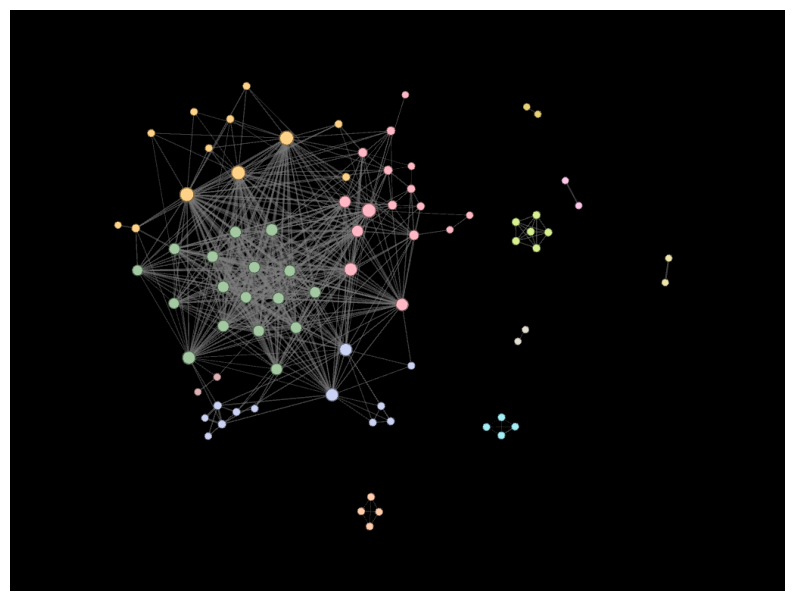

In [ ]:
# Importing the grapgh created in Gephi
img = mpimg.imread("Network_Images/Fund Network based on AUM pct_Overlap_top 500 Pairs.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

The graph shows clusters where stocks have major similar holdings in the top 10 Stocks. Thus, the funds are almost similar. The different communities are colored separately and the node size representst he degree of nodes (i.e number of connections) 

##### C.2 Top 20 Highly Separated Funds (Lowest degree)

Similary we find the funds that are more diverse , i.e. have lowest degrees thus more diverse and separated from the common funds.

In [238]:
# Degree of all funds in the overlap graph as (fund, degree) tuples
fund_degrees = list(G_top10_overlap.degree())

# Sort by degree ... get funds with least connections first
low_overlap_funds = sorted(fund_degrees, key=lambda x: x[1])[:20]

df_low_overlap = pd.DataFrame(low_overlap_funds, columns=['Fund', 'Number of Connections'])

df_low_overlap_with_return = df_low_overlap.merge(
    df_stocks[['Fund', 'Returns_3y']].drop_duplicates(subset='Fund'),  # Adjust the name as per your column
    on='Fund',
    how='left'
)

df_low_overlap_with_return

Fund  Number of Connections  \
0                Bandhan Small Cap Fund Direct Growth                      0   
1                    DSP Small Cap Direct Plan Growth                      1   
2   Parag Parikh Conservative Hybrid Fund Direct  ...                      1   
3                 Tata Small Cap Fund Direct   Growth                      2   
4            Motilal Oswal Focused Fund Direct Growth                      3   
5    Edelweiss Recently Listed IPO Fund Direct Growth                      6   
6                    SBI Small Cap Fund Direct Growth                      8   
7               LIC MF Small Cap Fund Direct   Growth                     10   
8   Franklin India Smaller Companies Fund Direct G...                     12   
9                Samco Flexi Cap Fund Direct   Growth                     12   
10                  Axis Small Cap Fund Direct Growth                     14   
11                 Kotak Small Cap Fund Direct Growth                     15   
12  ICICI Prudential Nifty Smallcap 250 Index Fund...                     18   
13           Edelweiss Small Cap Fund Direct   Growth                     20   
14                 HDFC Small Cap Fund Direct  Growth                     20   
15              Sundaram Small Cap Fund Direct Growth                     20   
16  Bandhan Conservative Hybrid Fund Direct Plan G...                     21   
17                  HSBC Small Cap Fund Direct Growth                     22   
18           LIC MF Infrastructure Fund Direct Growth                     22   
19                Taurus Mid Cap Fund Direct   Growth                     22   

    Returns_3y  
0         34.5  
1         24.2  
2         11.3  
3         26.9  
4         13.9  
5         16.2  
6         20.8  
7         24.2  
8         29.4  
9         -9.2  
10        23.8  
11        21.1  
12         6.0  
13        26.2  
14        28.0  
15        24.8  
16         9.2  
17        25.9  
18        33.8  
19        21.4

The top 10 funds show very few stocks based relationship with other funds. Additionally, on average the funds show a more than average returns for 3 years (comaprative to 10-15% average returns of Nifty Index).  
However, some funds e.x. SAmco Flexi cap, ICICI Prudential Nifty Smallcap provide less than average returns with Samco giving -10%.  
Furthermore, a few funds also provide average returns ~ 10%, eg Bandhan Conservative, Parag Parikh Conservative, Motilal Oswal Focused Fund Direct Growth.  

##### C.3 Popular Stocks in Top 10s

In [244]:
# fund_top10.values()

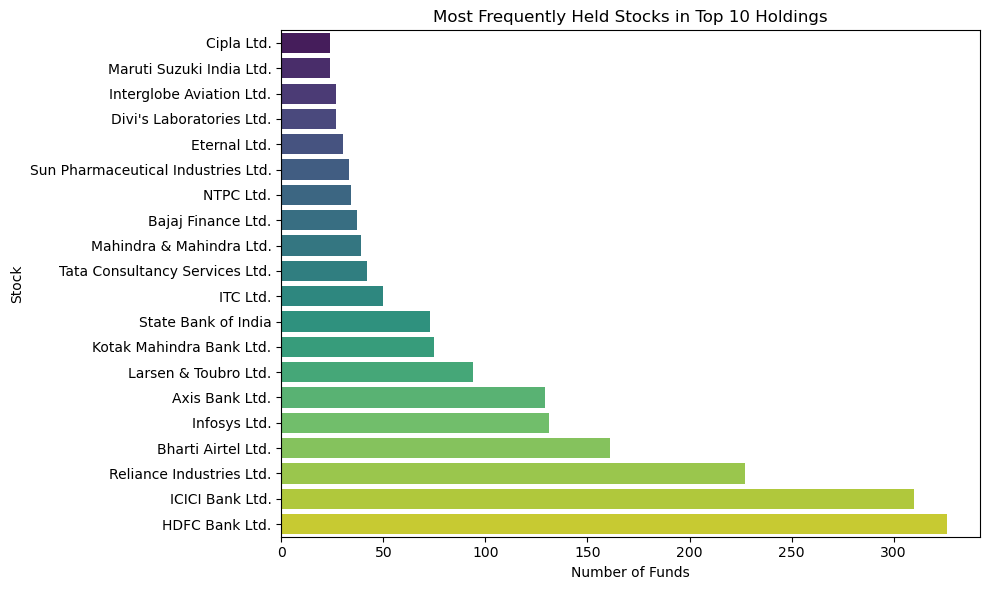

In [249]:
from collections import Counter

# Flatten all stock sets into a list from fund_top10  
all_top10_stocks = [stock for stocks in fund_top10.values() for stock in stocks]             # Extracting the Stock Names

# Count presence of stock
stock_counts = Counter(all_top10_stocks)                                                     # Count of Stock Name (i.e. more the count more funds investing in it)

# Top 20 most common stocks
df_popular_stocks = pd.DataFrame(
    stock_counts.most_common(20), 
    columns=['Stock', 'Frequency in Top 10 Holdings']
)

# Sorting data
df_popular_stocks_sorted = df_popular_stocks.sort_values('Frequency in Top 10 Holdings', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_popular_stocks_sorted,
    x='Frequency in Top 10 Holdings',
    y='Stock',
    hue='Stock',
    palette='viridis'
)

plt.title('Most Frequently Held Stocks in Top 10 Holdings')
plt.xlabel('Number of Funds')
plt.ylabel('Stock')
plt.tight_layout()
plt.show()

The plot shows that the HDFC Bank, ICICI Bank, Reliance Industries, Bharti Airtel Ltd., Infosys, Axis Bank, L&T, Kotack Bank, and SBI are among the top 10 preferred stocks by majority of mutual funds with more than 300 funds investing in ICICI and HDFC Banks.

#### C.4 Centrality Measures for G_top10_overlap

* Degree Centrality: Measures how many direct connections a node (fund) has to others, showing its immediate influence.

* Betweenness Centrality: Indicates how often a node lies on the shortest paths between other nodes, highlighting its role as a bridge or broker.

* Closeness Centrality: Reflects how close a node is to all other nodes in the network, capturing how quickly it can interact with others.

* Eigenvector Centrality: Assigns higher scores to nodes connected to other highly connected nodes, measuring overall influence in the network.

In [260]:
# Calculate centralities
degree_centrality = nx.degree_centrality(G_top10_overlap)
betweenness_centrality = nx.betweenness_centrality(G_top10_overlap)
closeness_centrality = nx.closeness_centrality(G_top10_overlap)
eigenvector_centrality = nx.eigenvector_centrality(G_top10_overlap, max_iter=1000)

# Combine into DataFrame
df_centralities = pd.DataFrame({
    'Fund': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': [betweenness_centrality.get(fund, 0) for fund in degree_centrality.keys()],
    'Closeness Centrality': [closeness_centrality.get(fund, 0) for fund in degree_centrality.keys()],
    'Eigenvector Centrality': [eigenvector_centrality.get(fund, 0) for fund in degree_centrality.keys()],
})

# Sort by Degree Centrality descending to see most connected funds on top
df_centralities = df_centralities.sort_values(by='Degree Centrality', ascending=False).reset_index(drop=True)

df_centralities.head(10)

Fund  Degree Centrality  \
0                      HSBC Value Fund Direct Growth           0.837209   
1          Kotak Focused Equity Fund Direct   Growth           0.835271   
2       Nippon India Quant Fund Retail Direct Growth           0.829457   
3    Axis Multi Asset Allocation Direct Plan  Growth           0.829457   
4             HSBC ELSS Tax Saver Fund Direct Growth           0.827519   
5             HDFC Equity Savings Direct Plan Growth           0.825581   
6  Mahindra Manulife Large & Mid Cap Fund Direct ...           0.823643   
7  Edelweiss NIFTY Large Mid Cap 250 Index Fund D...           0.821705   
8      Kotak Equity Opportunities Fund Direct Growth           0.819767   
9                  HSBC Flexi Cap Fund Direct Growth           0.819767   

   Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  
0                0.007121              0.858100                0.054219  
1                0.002612              0.856670                0.054456  
2                0.002468              0.852408                0.054451  
3                0.002369              0.852408                0.054446  
4                0.003291              0.850997                0.054384  
5                0.002248              0.849590                0.054365  
6                0.003562              0.848188                0.053254  
7                0.003335              0.846791                0.054345  
8                0.004046              0.845398                0.053333  
9                0.002786              0.845398                0.054266

**Overview**  

Degree Centrality: Funds like HSBC Value Fund and Kotak Focused Equity Fund have very high degree centrality (~0.83), which indicates that they share many common top stocks with other funds and these are highly connected and potentially less diversified.  

Betweenness Centrality: The betweeness centrality is smaller for these funds due to clusters, but the funds with higher betweenness like Mahindra Manulife Large & Mid Cap Fund (~0.00356) act as bridges connecting different clusters of funds, possibly influencing the flow of investment similarity.  

Closeness Centrality: High values (~0.85) indicate these funds are “close” to other funds in the network. Thus, they can be reached quickly through shared holdings, which highlights their central position.  

Eigenvector Centrality: These funds have moderate eigenvector scores (~0.054), thus they are connected to other well-connected funds, increasing their overall influence in the fund network.

#### Conclusion

*This project analyzed the overlap among mutual funds based on their stock holdings, and further analyzing the network with common holdings in the top 10 holdings, using network analysis to uncover relationships and diversification opportunities. High-overlap funds we identified that share many common investments, indicating potential redundancy in portfolios, and low-overlap funds that serve as diversifiers, and thus offers better portfolio risk mitigation.*

*Centrality measures—degree, betweenness, closeness, and eigenvector, helped highlight influential funds in the network. Funds with high degree centrality tend to be highly interconnected, indicating popular investment choices, while those with higher betweenness centrality act as bridges between clusters, playing a critical role in connecting diverse investment strategies.*

*The analysis of popular stocks across funds revealed key market favorites frequently held by multiple funds, reflecting common market trends and preferences.*

*Overall, this network-driven approach provides valuable insights for investors and portfolio managers aiming to optimize diversification, reduce redundant exposures, and identify central funds that influence market dynamics.*

*Future work could extend this by integrating fund performance metrics or analyzing fund families to detect mimicking behaviors within asset management companies.Analysis of Fund Managers and their investment styles to differnet stocks and sectors. Further a time series analysis for investments in different stocks and debt securities etc. will provide detailed insights in the investment domain.*